Rastrigin synthetic function:

GP EI versus GP dEI (winner)

https://www.sfu.ca/~ssurjano/rastr.html

In [1]:
pip install pyGPGO


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 kB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 13.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of arviz to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 

In [2]:
!pip install -q latextable


In [3]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc
rc('text', usetex=False)

from tabulate import tabulate
from texttable import Texttable

import latextable

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [4]:
### Inputs:

obj_func = 'Rastrigin'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util = 'EI'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [5]:
### Objective function:

if obj_func == 'Rastrigin':

    # True y bounds:
    y_lb = 0
    operator = -1 # targets global minimum
    y_global_orig = y_lb * operator # targets global minimum

# Constraints:
    lb = -5.12
    ub = +5.12

# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}

# Test data:
    x1_test = np.linspace(lb, ub, n_test)
    x2_test = np.linspace(lb, ub, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training):
        return operator * (10 * dim + x1_training** 2 - 10 * np.cos(2 * np.pi * x1_training)
                                    + x2_training** 2 - 10 * np.cos(2 * np.pi * x2_training)
                          )


In [6]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [7]:
### Cumulative Regret Calculator:

def min_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [8]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 1222
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [9]:
### Surrogate derivatives:

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)

def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE

    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T

        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)

        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.diag(np.dot(dKstar, alpha_Kstar))

        return dm, ds


In [10]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):
    def __init__(self, mode, eps=eps, **params):

        self.params = params
        self.eps = eps

        mode_dict = {
            'EI': self.EI
        }

        self.f = mode_dict[mode]

    def EI(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        #f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        f = (std + self.eps) * (norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx
        #df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df2 = (std + self.eps) * (-gamma * norm.pdf(gamma))
        df = df1 + df2
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()

    def d_eval(self, tau, mean, std, ds, dm):

        return self.f(tau, mean, std, ds, dm, **self.params)


In [11]:
n_start_AcqFunc = 20
inverse = -1
n_start = n_start_AcqFunc

maxfunMinimize = 50 * dim # allows for both function and gradient evaluation capping, using the problem's input dimensions


In [12]:
## GPGO_approx: BayesOpt class, acquision function optimised using approximate acquisition function gradients

class GPGO_approx(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval \t Proposed input x           \t Output y \t Best y \t nfev \t EI exact \t EI approx \t Ratio \t Euclid '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3} \t {:3} \t {:3} \t {:3} \t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):

        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        nfev = np.array([res.nfev for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.nfev = np.round(np.mean(nfev), 1)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.max_acqfuncApprox = -min(self.f_best) + eps
        self.history.append(self.max_acqfuncApprox)

        opt2 = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)

        x_best2 = np.array([res2.x for res2 in opt2])
        f_best2 = np.array([np.atleast_1d(res2.fun)[0] for res2 in opt2])
        self.x_best2 = x_best2
        self.f_best2 = f_best2
        self.best2 = x_best2[np.argmin(f_best2)]
        self.max_acqfuncExact = -min(self.f_best2) + eps
        self.history.append(self.max_acqfuncExact)
        self.history.append(self.nfev)

        self.euclid = np.sqrt(np.sum((self.x_best - self.start_points_arr)**2))
        self.history.append(self.euclid)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * np.round(self.GP.y[init_eval], 8), inverse * np.round(self.tau, 8), '', '', '', '', ''))

    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * np.round(self.GP.y[-1], 8))
        curr_best = str(inverse * np.round(self.tau, 8))
        f_gEvals = str(self.nfev)
        max_acqfuncExact = np.round(self.max_acqfuncExact, 8)
        max_acqfuncApprox = np.round(self.max_acqfuncApprox, 8)
        ratio = np.round(max_acqfuncExact/max_acqfuncApprox, 3)
        euclid = np.round(self.euclid, 3)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            f_gEvals = BOLD + OKGREEN + f_gEvals + ENDC
            max_acqfuncExact = BOLD + OKGREEN + str(max_acqfuncExact) + ENDC
            max_acqfuncApprox = BOLD + OKGREEN + str(max_acqfuncApprox) + ENDC
            ratio = BOLD + OKGREEN + str(ratio) + ENDC
            euclid = BOLD + OKGREEN + str(euclid) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_gEvals, max_acqfuncExact, max_acqfuncApprox, ratio, euclid))

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [13]:
## GPGO_exact: BayesOpt class, acquision function optimised using exact acquisition function gradients

class GPGO_exact(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval \t Proposed input x           \t Output y \t Best y \t nfev \t EI exact \t EI approx \t Ratio \t Euclid '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3} \t {:3} \t {:3} \t {:3} \t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):

        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        nfev = np.array([res.nfev for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.nfev = np.round(np.mean(nfev), 1)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.max_acqfuncExact = -min(self.f_best) + eps
        self.history.append(self.max_acqfuncExact)

        opt2 = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)

        x_best2 = np.array([res2.x for res2 in opt2])
        f_best2 = np.array([np.atleast_1d(res2.fun)[0] for res2 in opt2])
        self.x_best2 = x_best2
        self.f_best2 = f_best2
        self.best2 = x_best2[np.argmin(f_best2)]
        self.max_acqfuncApprox = -min(self.f_best2) + eps
        self.history.append(self.max_acqfuncApprox)
        self.history.append(self.nfev)

        self.euclid = np.sqrt(np.sum((self.x_best - self.start_points_arr)**2))
        self.history.append(self.euclid)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * np.round(self.GP.y[init_eval], 8), inverse * np.round(self.tau, 8), '', '', '', '', ''))

    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)

        curr_eval = str(inverse * np.round(self.GP.y[-1], 8))
        curr_best = str(inverse * np.round(self.tau, 8))
        f_gEvals = str(self.nfev)
        max_acqfuncExact = np.round(self.max_acqfuncExact, 8)
        max_acqfuncApprox = np.round(self.max_acqfuncApprox, 8)
        ratio = np.round(max_acqfuncExact/max_acqfuncApprox, 3)
        euclid = np.round(self.euclid, 3)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            f_gEvals = BOLD + OKGREEN + f_gEvals + ENDC
            max_acqfuncExact = BOLD + OKGREEN + str(max_acqfuncExact) + ENDC
            max_acqfuncApprox = BOLD + OKGREEN + str(max_acqfuncApprox) + ENDC
            ratio = BOLD + OKGREEN + str(ratio) + ENDC
            euclid = BOLD + OKGREEN + str(euclid) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_gEvals, max_acqfuncExact, max_acqfuncApprox, ratio, euclid))

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [14]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_1 = GPGO_approx(surrogate_approx_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-0.84969467  2.25612281]	 20.33436271	 19.90840325	     	     	     	     	    
init	 [-5.1188288  -2.02411446]	 33.07414982	 19.90840325	     	     	     	     	    
init	 [-3.61721968 -4.17445279]	 53.34797472	 19.90840325	     	     	     	     	    
init	 [-3.21269544 -1.58145816]	 39.21847231	 19.90840325	     	     	     	     	    
init	 [-1.05710106  0.39748336]	 19.90840325	 19.90840325	     	     	     	     	    
1  	 [-4.42713415 -3.2251777 ]	 57.41811092	 19.90840325	 10.5 	 0.73270892 	 0.7611621 	 0.963 	 0.598
2  	 [-0.51289975  0.80270965]	 27.62294622	 19.90840325	 3.0 	 5.8e-07 	 5.8e-07 	 1.0 	 0.0
3  	 [-2.82702153 -3.05554675]	 23.27859275	 19.90840325	 24.2 	 0.74428101 	 0.76974159 	 0.967 	 1.652
4  	 [-4.11304454 -1.33182687]	 36.02690799	 19.90840325	 15.9 	 0.69575391 	 0.73526502 	 0.946 	 1.693
5  	 [-2.75018243 -1.9499809 ]	 21.84427197	 19.9084032

In [15]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_2 = GPGO_approx(surrogate_approx_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-0.6554122  -4.85451539]	 43.49029625	 18.96453942	     	     	     	     	    
init	 [ 0.50854377 -0.6622987 ]	 35.91861668	 18.96453942	     	     	     	     	    
init	 [-0.81543371 -1.73737143]	 20.47956205	 18.96453942	     	     	     	     	    
init	 [-3.02439799  1.2213347 ]	 18.96453942	 18.96453942	     	     	     	     	    
init	 [-2.05153614 -2.3876887 ]	 28.04131567	 18.96453942	     	     	     	     	    
1	 [ 0.25941111 -0.852406  ]	 15.3853847	 15.3853847	 9.3 	 0.00158094 	 0.69213915 	 0.002 	 1.433
2  	 [-1.10831127 -3.87438355]	 21.42324282	 15.3853847	 32.7 	 0.74586456 	 0.76124234 	 0.98 	 2.214
3  	 [ 0.18905205 -4.63786366]	 44.28604992	 15.3853847	 19.2 	 0.74756605 	 0.74768132 	 1.0 	 2.092
4  	 [ 0.27421742 -3.54700041]	 43.73928078	 15.3853847	 12.0 	 0.71791012 	 0.75796825 	 0.947 	 1.656
5  	 [ 0.54436118 -2.52447451]	 46.16535291	 15.385384

In [16]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_3 = GPGO_approx(surrogate_approx_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [0.52017052 2.1314337 ]	 27.95385841	 10.60766264	     	     	     	     	    
init	 [-2.14113547  0.11087468]	 10.60766264	 10.60766264	     	     	     	     	    
init	 [4.02377681 4.05804123]	 33.42749829	 10.60766264	     	     	     	     	    
init	 [-3.83400642 -2.99783293]	 28.65095393	 10.60766264	     	     	     	     	    
init	 [-4.59297584 -0.6061072 ]	 57.66313556	 10.60766264	     	     	     	     	    
1  	 [-4.35881778  0.80212185]	 42.74283553	 10.60766264	 40.4 	 0.78405112 	 0.78438984 	 1.0 	 3.713
2  	 [-5.12      -2.2200922]	 41.98540068	 10.60766264	 32.7 	 0.76611722 	 0.78192144 	 0.98 	 10.931
3  	 [-3.07451665 -1.46365411]	 32.41149582	 10.60766264	 57.8 	 0.78277845 	 0.78443906 	 0.998 	 4.382
4  	 [-5.12       -3.56895522]	 60.73818102	 10.60766264	 31.2 	 0.73870851 	 0.77133128 	 0.958 	 3.718
5  	 [-5.12        1.63486103]	 48.21715025	 10.607

In [17]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number =  4

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_4 = GPGO_approx(surrogate_approx_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [4.78238555 0.48365823]	 51.03163809	 14.32303826	     	     	     	     	    
init	 [4.84028785 2.19971578]	 39.78645699	 14.32303826	     	     	     	     	    
init	 [ 2.02474316 -2.90724357]	 14.32303826	 14.32303826	     	     	     	     	    
init	 [ 4.87705042 -5.05620219]	 52.80627247	 14.32303826	     	     	     	     	    
init	 [-2.52946061 -0.66773471]	 41.61497868	 14.32303826	     	     	     	     	    
1  	 [-3.20634969 -1.20932837]	 26.50702725	 14.32303826	 5.7 	 0.74351567 	 0.74925277 	 0.992 	 0.378
2  	 [-1.76234341 -1.21058109]	 21.34506061	 14.32303826	 8.0 	 7.18e-06 	 0.75335279 	 0.0 	 1.065
3  	 [3.62869344 1.23641517]	 40.74869783	 14.32303826	 25.8 	 0.7675061 	 0.77590659 	 0.989 	 1.869
4  	 [ 3.97487207 -4.37566522]	 52.1709924	 14.32303826	 39.8 	 0.76752544 	 0.76926325 	 0.998 	 3.866
5  	 [ 3.70955685 -0.23682319]	 35.50377735	 14.32303826	

In [18]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_5 = GPGO_approx(surrogate_approx_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.84678993  3.79629882]	 33.93442009	 7.8108627	     	     	     	     	    
init	 [-3.00319585  4.2865757 ]	 39.67387608	 7.8108627	     	     	     	     	    
init	 [-0.11866943  1.14425716]	 7.8108627	 7.8108627	     	     	     	     	    
init	 [2.72289645 0.1886002 ]	 25.38160396	 7.8108627	     	     	     	     	    
init	 [-2.08076286 -3.19773462]	 22.58998212	 7.8108627	     	     	     	     	    
1  	 [-4.44540382  3.85581624]	 57.87679251	 7.8108627	 57.4 	 0.78291874 	 0.78508541 	 0.997 	 15.414
2  	 [-1.68564918  4.70754934]	 51.57218581	 7.8108627	 55.0 	 0.77419967 	 0.77894499 	 0.994 	 7.315
3  	 [-4.14840487  2.20871282]	 33.56388385	 7.8108627	 65.6 	 0.78741139 	 0.7909639 	 0.996 	 10.017
4  	 [-0.94194404  3.25658889]	 22.56446784	 7.8108627	 70.2 	 0.76139198 	 0.78923742 	 0.965 	 8.854
5  	 [-0.17115438  5.0790137 ]	 32.2790704	 7.8108627	 68.8 	 0.

In [19]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_6 = GPGO_approx(surrogate_approx_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 4.02288795 -1.72052679]	 31.0883571	 17.28954483	     	     	     	     	    
init	 [ 3.28938622 -4.69302655]	 58.79786772	 17.28954483	     	     	     	     	    
init	 [-4.0175956   0.97333314]	 17.28954483	 17.28954483	     	     	     	     	    
init	 [ 0.30532979 -0.83141193]	 19.29625316	 17.28954483	     	     	     	     	    
init	 [-1.68542362  1.25459899]	 28.65063094	 17.28954483	     	     	     	     	    
1  	 [ 3.29827354 -3.53261675]	 56.13554981	 17.28954483	 16.0 	 0.32005281 	 0.76916107 	 0.416 	 2.311
2  	 [ 4.58261495 -4.02014594]	 55.92467393	 17.28954483	 17.8 	 0.77178454 	 0.77585667 	 0.995 	 2.607
3  	 [ 2.1026375  -4.21045658]	 31.69827055	 17.28954483	 8.0 	 0.20969652 	 0.76922918 	 0.273 	 0.711
4  	 [ 3.23673498 -0.8274397 ]	 25.65265934	 17.28954483	 3.2 	 1.38e-06 	 1.38e-06 	 1.0 	 0.0
5  	 [-1.77712498  1.22079348]	 21.12761849	 17.289544

In [20]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_7 = GPGO_approx(surrogate_approx_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_7.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-4.33860312  2.86636843]	 45.64613307	 22.52235438	     	     	     	     	    
init	 [-0.63068947  2.28828342]	 34.83012663	 22.52235438	     	     	     	     	    
init	 [4.8946126  0.39419771]	 44.09657006	 22.52235438	     	     	     	     	    
init	 [ 0.01147355 -4.38219639]	 36.61320982	 22.52235438	     	     	     	     	    
init	 [-2.37118484e+00 -1.20319155e-03]	 22.52235438	 22.52235438	     	     	     	     	    
1  	 [-0.75311646  1.37606238]	 29.38304222	 22.52235438	 3.2 	 5.9e-07 	 5.9e-07 	 1.0 	 0.0
2  	 [-4.23554544  3.01507709]	 36.16841353	 22.52235438	 13.6 	 0.22447152 	 0.69441456 	 0.323 	 1.721
3  	 [-4.38259885  2.28632913]	 54.09781903	 22.52235438	 15.8 	 0.15818296 	 0.70574666 	 0.224 	 2.058
4	 [-0.72230017  1.90086977]	 17.74451108	 17.74451108	 7.4 	 0.00165309 	 0.61581162 	 0.003 	 1.155
5  	 [4.35542282 0.77852447]	 43.94318283	 17.74451

In [21]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_8 = GPGO_approx(surrogate_approx_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [3.82391708 4.79785639]	 50.20079447	 13.87182102	     	     	     	     	    
init	 [3.78055209 0.31596228]	 36.51142516	 13.87182102	     	     	     	     	    
init	 [-2.73686192 -5.00327624]	 43.34985765	 13.87182102	     	     	     	     	    
init	 [-0.7119993  -0.99992207]	 13.87182102	 13.87182102	     	     	     	     	    
init	 [ 0.23218863 -0.22126801]	 17.19059036	 13.87182102	     	     	     	     	    
1  	 [4.70880479 4.15957942]	 56.65394807	 13.87182102	 10.8 	 0.76686764 	 0.76690053 	 1.0 	 0.489
2  	 [3.58903927 3.24609757]	 51.64865023	 13.87182102	 20.4 	 0.73323601 	 0.78122524 	 0.939 	 1.912
3  	 [4.91641103 2.58740677]	 50.7430203	 13.87182102	 34.4 	 0.76209019 	 0.78080891 	 0.976 	 2.622
4  	 [3.16827939 1.79612101]	 25.49457506	 13.87182102	 27.3 	 0.75644953 	 0.77853867 	 0.972 	 2.53
5  	 [2.50645162 4.19605831]	 50.55624969	 13.87182102	 20.

In [22]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_9 = GPGO_approx(surrogate_approx_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-5.01376866  0.01919582]	 25.24828903	 24.45480031	     	     	     	     	    
init	 [-0.04328148 -3.74958562]	 24.45480031	 24.45480031	     	     	     	     	    
init	 [-3.66478248 -2.88195916]	 39.46509427	 24.45480031	     	     	     	     	    
init	 [-0.83447623 -2.57944404]	 31.06766398	 24.45480031	     	     	     	     	    
init	 [-4.25922917 -1.58209393]	 49.92254356	 24.45480031	     	     	     	     	    
1  	 [-3.46181228 -1.79114049]	 42.34960724	 24.45480031	 7.0 	 0.32257177 	 0.72649698 	 0.444 	 0.873
2	 [-4.06474147 -0.09627597]	 19.12192952	 19.12192952	 3.2 	 1.11e-06 	 1.11e-06 	 1.0 	 0.0
3  	 [-2.81041895 -1.42139571]	 35.01808955	 19.12192952	 9.2 	 0.71460704 	 0.73552229 	 0.972 	 1.276
4  	 [-4.88181904 -2.41338688]	 50.84453057	 19.12192952	 21.8 	 0.7166002 	 0.75110206 	 0.954 	 2.55
5  	 [-4.78943988 -3.38874534]	 59.62417752	 19.12192952	 

In [23]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_10 = GPGO_approx(surrogate_approx_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 2.77832339 -4.90750004]	 41.67433019	 13.83945831	     	     	     	     	    
init	 [1.36855793 2.54775176]	 44.69639719	 13.83945831	     	     	     	     	    
init	 [-0.01528819 -2.81808235]	 13.83945831	 13.83945831	     	     	     	     	    
init	 [-3.09183626  2.66783449]	 33.23221511	 13.83945831	     	     	     	     	    
init	 [-3.38830503 -4.2154003 ]	 54.73014367	 13.83945831	     	     	     	     	    
1  	 [-2.26735806 -3.81740132]	 36.69245192	 13.83945831	 33.0 	 0.77245935 	 0.77298618 	 0.999 	 1.582
2  	 [-3.57677074 -2.92084462]	 41.39511695	 13.83945831	 33.6 	 0.77595795 	 0.77613693 	 1.0 	 4.018
3  	 [-4.70388746 -3.97026701]	 50.92054476	 13.83945831	 36.3 	 0.75813176 	 0.77537558 	 0.978 	 3.232
4  	 [-4.95934033 -5.12      ]	 53.84432957	 13.83945831	 40.4 	 0.76767111 	 0.77123938 	 0.995 	 4.152
5  	 [-2.34378024 -2.53099571]	 47.26748463	 13

In [24]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_11 = GPGO_approx(surrogate_approx_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-3.27403839 -4.92057353]	 47.65564129	 10.67975525	     	     	     	     	    
init	 [-0.37664229  2.30332343]	 35.87889241	 10.67975525	     	     	     	     	    
init	 [-0.81711509 -0.14922651]	 10.67975525	 10.67975525	     	     	     	     	    
init	 [-4.98912446 -0.12931474]	 28.05462906	 10.67975525	     	     	     	     	    
init	 [4.52410012 3.59214172]	 71.62694632	 10.67975525	     	     	     	     	    
1  	 [4.81931973 5.12      ]	 57.9314769	 10.67975525	 42.6 	 0.78890715 	 0.7889726 	 1.0 	 6.913
2  	 [3.00022606 4.45355003]	 48.41259584	 10.67975525	 63.2 	 0.77717915 	 0.79169508 	 0.982 	 5.954
3  	 [-3.67639705 -3.71705804]	 53.8489923	 10.67975525	 30.2 	 0.77765802 	 0.77766392 	 1.0 	 5.485
4  	 [-2.77286469 -2.71467975]	 35.82763552	 10.67975525	 31.5 	 0.779704 	 0.78153372 	 0.998 	 4.308
5  	 [-4.3965692  -2.34165793]	 58.22070764	 10.67975525	 

In [25]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_12 = GPGO_approx(surrogate_approx_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-4.42895074 -1.69018374]	 55.16283851	 22.67386745	     	     	     	     	    
init	 [-1.34764292 -0.1679887 ]	 22.67386745	 22.67386745	     	     	     	     	    
init	 [-0.3705575  -4.73210732]	 50.52298005	 22.67386745	     	     	     	     	    
init	 [-4.44775178 -4.23119156]	 65.97242399	 22.67386745	     	     	     	     	    
init	 [ 4.66646945 -3.32011352]	 62.07406417	 22.67386745	     	     	     	     	    
1  	 [-5.09036992 -1.69377337]	 43.80972463	 22.67386745	 8.1 	 0.72510747 	 0.73059069 	 0.992 	 0.448
2  	 [-3.83808575 -2.85842521]	 31.34747711	 22.67386745	 15.0 	 0.7344023 	 0.76903958 	 0.955 	 1.983
3  	 [ 0.12265327 -3.56004469]	 34.81113518	 22.67386745	 3.0 	 4e-08 	 4e-08 	 1.0 	 0.0
4  	 [ 4.09973708 -2.76403361]	 35.46724185	 22.67386745	 11.7 	 0.74281052 	 0.74282749 	 1.0 	 0.66
5  	 [-3.74869507 -1.34737636]	 41.69382277	 22.67386745	 8.0 	

In [26]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_13 = GPGO_approx(surrogate_approx_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 2.84367268 -2.68757791]	 33.5801983	 17.43582664	     	     	     	     	    
init	 [3.32061217 4.76927179]	 56.857058	 17.43582664	     	     	     	     	    
init	 [ 4.83943541 -0.47667971]	 48.21191936	 17.43582664	     	     	     	     	    
init	 [1.11659482 2.82139151]	 17.43582664	 17.43582664	     	     	     	     	    
init	 [1.45012065 2.27346667]	 38.25352329	 17.43582664	     	     	     	     	    
1  	 [2.65594558 3.82243987]	 42.84069095	 17.43582664	 20.2 	 0.70415874 	 0.76718001 	 0.918 	 1.846
2  	 [2.16169526 5.12      ]	 38.32960932	 17.43582664	 18.4 	 0.62190225 	 0.76707677 	 0.811 	 3.896
3  	 [1.45506038 4.22442311]	 47.96681123	 17.43582664	 11.7 	 0.38311605 	 0.74655613 	 0.513 	 1.022
4  	 [2.70781567 2.76277383]	 36.78303719	 17.43582664	 6.2 	 0.00028564 	 0.74980442 	 0.0 	 0.861
5  	 [4.04541179 3.8138307 ]	 37.41102942	 17.43582664	 22.4 	 

In [27]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_14 = GPGO_approx(surrogate_approx_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [0.14277984 2.79721013]	 18.68308526	 10.4238386	     	     	     	     	    
init	 [ 3.7931795  -5.03759925]	 47.36348784	 10.4238386	     	     	     	     	    
init	 [-1.94830412  4.68586229]	 40.19779334	 10.4238386	     	     	     	     	    
init	 [ 0.13431513 -1.86076749]	 10.4238386	 10.4238386	     	     	     	     	    
init	 [ 0.40140736 -2.85434939]	 30.35354874	 10.4238386	     	     	     	     	    
1  	 [ 4.14917605 -3.80473762]	 42.40017008	 10.4238386	 31.8 	 0.77806454 	 0.77838489 	 1.0 	 3.925
2  	 [ 1.25494937 -3.17829159]	 27.63269098	 10.4238386	 13.6 	 0.72621657 	 0.75292609 	 0.965 	 2.013
3  	 [-0.67987674  4.39401537]	 51.8978838	 10.4238386	 33.6 	 0.77512399 	 0.77539395 	 1.0 	 4.626
4  	 [ 2.29489527 -4.65613337]	 55.29150747	 10.4238386	 32.2 	 0.76408415 	 0.78439397 	 0.974 	 3.947
5  	 [-1.74133214  3.06981932]	 23.94727813	 10.4238386	 27.

In [28]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_15 = GPGO_approx(surrogate_approx_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 3.57189322 -3.28810573]	 54.93848777	 7.99076531	     	     	     	     	    
init	 [-4.56332069 -1.41784631]	 60.75019875	 7.99076531	     	     	     	     	    
init	 [-2.29989449  0.3072023 ]	 31.98499725	 7.99076531	     	     	     	     	    
init	 [-1.9873903  -2.00218256]	 7.99076531	 7.99076531	     	     	     	     	    
init	 [-3.97576933 -2.5610341 ]	 41.75495777	 7.99076531	     	     	     	     	    
1  	 [-4.33210339  0.32275286]	 48.2178682	 7.99076531	 67.6 	 0.78995619 	 0.79161912 	 0.998 	 10.864
2  	 [ 2.01818658 -3.52948127]	 36.42445948	 7.99076531	 35.6 	 0.78936038 	 0.78941141 	 1.0 	 4.414
3  	 [ 3.30463827 -4.98642729]	 49.18741844	 7.99076531	 50.8 	 0.78563658 	 0.79123828 	 0.993 	 5.038
4  	 [ 5.07001594 -4.34876471]	 61.38385586	 7.99076531	 52.0 	 0.78666077 	 0.79204676 	 0.993 	 9.02
5  	 [ 4.50670539 -2.02572487]	 44.5354247	 7.99076531	 

In [29]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_16 = GPGO_approx(surrogate_approx_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.83349935  0.23719262]	 22.27210457	 22.27210457	     	     	     	     	    
init	 [ 0.51918292 -4.65303603]	 57.57021076	 22.27210457	     	     	     	     	    
init	 [-1.42613673 -2.83565116]	 33.89145899	 22.27210457	     	     	     	     	    
init	 [ 1.9325559  -3.44339021]	 35.85029586	 22.27210457	     	     	     	     	    
init	 [-4.39987336  4.51595121]	 77.78800882	 22.27210457	     	     	     	     	    
1  	 [ 1.51852911 -4.77618898]	 53.41213192	 22.27210457	 5.4 	 0.74660262 	 0.74962234 	 0.996 	 0.233
2  	 [-5.11999974  3.74271232]	 53.39033408	 22.27210457	 7.4 	 0.71038416 	 0.76450846 	 0.929 	 0.937
3  	 [ 0.45449611 -3.49784942]	 52.03466014	 22.27210457	 17.0 	 0.71937823 	 0.76038644 	 0.946 	 1.359
4  	 [ 0.74593227 -2.7672115 ]	 27.39010568	 22.27210457	 11.2 	 0.7248442 	 0.73355565 	 0.988 	 1.255
5  	 [-4.41159677  3.0576836 ]	 47.95787048	 2

In [30]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_17 = GPGO_approx(surrogate_approx_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.10263037  0.31320838]	 20.39514536	 20.39514536	     	     	     	     	    
init	 [-3.15882714 -4.42470033]	 53.03732051	 20.39514536	     	     	     	     	    
init	 [2.93873111 1.60085526]	 29.98922481	 20.39514536	     	     	     	     	    
init	 [1.40821398 0.77417363]	 29.45198942	 20.39514536	     	     	     	     	    
init	 [-4.71999574 -1.45598869]	 55.89242174	 20.39514536	     	     	     	     	    
1	 [-3.97349432 -1.07725176]	 18.24254215	 18.24254215	 18.0 	 0.74408052 	 0.74622776 	 0.997 	 1.63
2  	 [3.79950778 2.18199587]	 31.99263179	 18.24254215	 3.2 	 7.5e-07 	 7.5e-07 	 1.0 	 0.0
3  	 [-4.58967357 -2.44104514]	 64.79979431	 18.24254215	 23.2 	 0.73690699 	 0.75798522 	 0.972 	 3.002
4  	 [-3.17776076 -2.84460555]	 28.20495343	 18.24254215	 31.6 	 0.75173878 	 0.77731072 	 0.967 	 3.293
5  	 [-2.26853064 -4.18701926]	 39.98432368	 18.24254215	 13.0 

In [31]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_18 = GPGO_approx(surrogate_approx_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [1.53983224 0.05584255]	 22.67190581	 22.67190581	     	     	     	     	    
init	 [ 3.87687906 -3.25795609]	 38.99009942	 22.67190581	     	     	     	     	    
init	 [3.60686662 2.56139557]	 56.66448699	 22.67190581	     	     	     	     	    
init	 [1.70088108 4.99604939]	 40.89405932	 22.67190581	     	     	     	     	    
init	 [-2.48864335 -4.83014733]	 54.67257498	 22.67190581	     	     	     	     	    
1  	 [-1.94749824 -5.12      ]	 33.25664537	 22.67190581	 6.8 	 0.29060108 	 0.72614776 	 0.4 	 1.597
2  	 [3.13087205 3.14062676]	 26.51662252	 22.67190581	 13.5 	 0.73191952 	 0.73833365 	 0.991 	 1.181
3  	 [3.4974101  1.86548328]	 39.07471569	 22.67190581	 22.4 	 0.70777306 	 0.73265597 	 0.966 	 1.61
4  	 [1.73381197 4.9530495 ]	 38.98614903	 22.67190581	 6.0 	 0.00168146 	 0.34459857 	 0.005 	 0.901
5  	 [4.41387428 2.60862491]	 62.61832728	 22.67190581	 22.8

In [32]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_19 = GPGO_approx(surrogate_approx_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-4.12125592  2.6751971 ]	 41.43485596	 25.86700384	     	     	     	     	    
init	 [-2.59135515 -3.70553152]	 51.60126035	 25.86700384	     	     	     	     	    
init	 [-1.72598719 -4.27008445]	 43.97430127	 25.86700384	     	     	     	     	    
init	 [1.76104531 3.13952049]	 25.86700384	 25.86700384	     	     	     	     	    
init	 [4.9432772  1.38916592]	 44.66580307	 25.86700384	     	     	     	     	    
1  	 [4.94055661 1.39066294]	 44.76407721	 25.86700384	 3.8 	 0.01009335 	 0.08709343 	 0.116 	 0.392
2  	 [4.96411722 2.57670389]	 50.39589688	 25.86700384	 3.0 	 5e-08 	 5e-08 	 1.0 	 0.0
3  	 [-1.92003301 -3.33870675]	 31.35890774	 25.86700384	 5.7 	 0.46656662 	 0.71939952 	 0.649 	 1.446
4  	 [-1.42150701 -3.84531204]	 39.97835786	 25.86700384	 12.9 	 0.67213319 	 0.68466247 	 0.982 	 0.875
5  	 [-2.47343094 -4.60857908]	 64.97957617	 25.86700384	 13.0 	 0.1

In [33]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_20 = GPGO_approx(surrogate_approx_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [0.9024594  4.07258857]	 20.24255448	 17.38869134	     	     	     	     	    
init	 [4.00927467 3.23417577]	 35.55852255	 17.38869134	     	     	     	     	    
init	 [-4.75249064  1.96359764]	 36.54582989	 17.38869134	     	     	     	     	    
init	 [-1.24230715  0.18955208]	 17.38869134	 17.38869134	     	     	     	     	    
init	 [ 1.61742301 -3.13497377]	 33.2293287	 17.38869134	     	     	     	     	    
1  	 [-4.43013196  2.01754856]	 42.8090946	 17.38869134	 17.0 	 0.70180921 	 0.70218093 	 0.999 	 2.267
2  	 [-4.16000583  2.83572259]	 34.85957169	 17.38869134	 15.3 	 0.73611982 	 0.74038828 	 0.994 	 1.641
3  	 [3.82164309 3.39866588]	 49.8455234	 17.38869134	 10.5 	 0.69631856 	 0.69735941 	 0.999 	 1.255
4  	 [2.8061409  3.57405444]	 46.13043349	 17.38869134	 31.6 	 0.74582054 	 0.75628147 	 0.986 	 1.929
5  	 [3.01425891 2.35767614]	 30.9455598	 17.38869134	

In [34]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_1 = GPGO_exact(surrogate_exact_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-0.84969467  2.25612281]	 20.33436271	 19.90840325	     	     	     	     	    
init	 [-5.1188288  -2.02411446]	 33.07414982	 19.90840325	     	     	     	     	    
init	 [-3.61721968 -4.17445279]	 53.34797472	 19.90840325	     	     	     	     	    
init	 [-3.21269544 -1.58145816]	 39.21847231	 19.90840325	     	     	     	     	    
init	 [-1.05710106  0.39748336]	 19.90840325	 19.90840325	     	     	     	     	    
1  	 [-3.78850742 -4.92168235]	 47.36628979	 19.90840325	 2.7 	 0.73270892 	 0.7611621 	 0.963 	 0.0
2  	 [-3.00608028 -3.36657701]	 37.06477459	 19.90840325	 2.4 	 0.75712277 	 0.7615753 	 0.994 	 0.494
3  	 [-2.70685936 -2.20476646]	 32.06161844	 19.90840325	 5.6 	 0.72427925 	 0.76509432 	 0.947 	 0.469
4  	 [-2.51914418 -4.53986154]	 66.57216475	 19.90840325	 4.2 	 0.75471305 	 0.76511002 	 0.986 	 0.7
5  	 [-2.26985361 -2.45255119]	 41.97032423	 19.90840

In [35]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_2 = GPGO_exact(surrogate_exact_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-0.6554122  -4.85451539]	 43.49029625	 18.96453942	     	     	     	     	    
init	 [ 0.50854377 -0.6622987 ]	 35.91861668	 18.96453942	     	     	     	     	    
init	 [-0.81543371 -1.73737143]	 20.47956205	 18.96453942	     	     	     	     	    
init	 [-3.02439799  1.2213347 ]	 18.96453942	 18.96453942	     	     	     	     	    
init	 [-2.05153614 -2.3876887 ]	 28.04131567	 18.96453942	     	     	     	     	    
1  	 [-0.74192934 -0.64770803]	 27.470607	 18.96453942	 3.4 	 0.00158094 	 0.69213915 	 0.002 	 0.396
2  	 [ 0.52736744 -0.31403249]	 34.14486978	 18.96453942	 6.5 	 0.69618336 	 0.72755251 	 0.957 	 0.901
3  	 [-0.20561093 -5.12      ]	 36.21396088	 18.96453942	 3.2 	 0.71778867 	 0.72368326 	 0.992 	 0.66
4	 [0.18283204 0.23270475]	 14.90690395	 14.90690395	 4.8 	 0.71115029 	 0.71484104 	 0.995 	 1.009
5  	 [ 0.04379184 -3.94928385]	 16.47835807	 14.906903

In [36]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_3 = GPGO_exact(surrogate_exact_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [0.52017052 2.1314337 ]	 27.95385841	 10.60766264	     	     	     	     	    
init	 [-2.14113547  0.11087468]	 10.60766264	 10.60766264	     	     	     	     	    
init	 [4.02377681 4.05804123]	 33.42749829	 10.60766264	     	     	     	     	    
init	 [-3.83400642 -2.99783293]	 28.65095393	 10.60766264	     	     	     	     	    
init	 [-4.59297584 -0.6061072 ]	 57.66313556	 10.60766264	     	     	     	     	    
1  	 [-5.00164002  0.74498545]	 35.88695863	 10.60766264	 13.6 	 0.78405112 	 0.78438984 	 1.0 	 2.637
2  	 [-3.49449968  0.84709512]	 37.19390641	 10.60766264	 14.4 	 0.77652471 	 0.77739688 	 0.999 	 9.724
3  	 [-3.04566371 -1.26029932]	 21.9198767	 10.60766264	 13.9 	 0.78263002 	 0.78386066 	 0.998 	 2.727
4  	 [1.23241239 2.42641297]	 35.25352464	 10.60766264	 8.8 	 0.73871968 	 0.78189954 	 0.945 	 1.63
5  	 [-4.84847489  1.85009224]	 35.24795047	 10.607662

In [37]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_4 = GPGO_exact(surrogate_exact_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [4.78238555 0.48365823]	 51.03163809	 14.32303826	     	     	     	     	    
init	 [4.84028785 2.19971578]	 39.78645699	 14.32303826	     	     	     	     	    
init	 [ 2.02474316 -2.90724357]	 14.32303826	 14.32303826	     	     	     	     	    
init	 [ 4.87705042 -5.05620219]	 52.80627247	 14.32303826	     	     	     	     	    
init	 [-2.52946061 -0.66773471]	 41.61497868	 14.32303826	     	     	     	     	    
1  	 [-3.27934599 -0.19647916]	 29.32635694	 14.32303826	 5.3 	 0.74351567 	 0.74925277 	 0.992 	 1.071
2  	 [-2.44815711 -0.89628455]	 28.3201854	 14.32303826	 2.7 	 2.516e-05 	 0.75300021 	 0.0 	 0.0
3  	 [ 5.12       -3.96874308]	 44.86786737	 14.32303826	 8.7 	 0.7675061 	 0.77590659 	 0.989 	 0.916
4  	 [-2.62023127  0.54006041]	 44.12189548	 14.32303826	 9.2 	 0.74611071 	 0.77718292 	 0.96 	 0.894
5  	 [-1.70936666  0.92198874]	 17.47484105	 14.32303826	 1

In [38]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_5 = GPGO_exact(surrogate_exact_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.84678993  3.79629882]	 33.93442009	 7.8108627	     	     	     	     	    
init	 [-3.00319585  4.2865757 ]	 39.67387608	 7.8108627	     	     	     	     	    
init	 [-0.11866943  1.14425716]	 7.8108627	 7.8108627	     	     	     	     	    
init	 [2.72289645 0.1886002 ]	 25.38160396	 7.8108627	     	     	     	     	    
init	 [-2.08076286 -3.19773462]	 22.58998212	 7.8108627	     	     	     	     	    
1  	 [-1.42739097  3.81528798]	 41.58304871	 7.8108627	 25.4 	 0.78291874 	 0.78508541 	 0.997 	 20.945
2  	 [-0.22455517  4.39110727]	 45.48959624	 7.8108627	 23.6 	 0.77999486 	 0.78381049 	 0.995 	 4.045
3  	 [1.17076056 4.52010237]	 46.94673883	 7.8108627	 20.9 	 0.78319401 	 0.78708333 	 0.995 	 3.6
4  	 [0.93411647 2.81613445]	 15.61103438	 7.8108627	 24.5 	 0.78134288 	 0.79001527 	 0.989 	 5.558
5  	 [3.34927004 0.97678371]	 28.11860682	 7.8108627	 24.4 	 0.7589293

In [39]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_6 = GPGO_exact(surrogate_exact_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 4.02288795 -1.72052679]	 31.0883571	 17.28954483	     	     	     	     	    
init	 [ 3.28938622 -4.69302655]	 58.79786772	 17.28954483	     	     	     	     	    
init	 [-4.0175956   0.97333314]	 17.28954483	 17.28954483	     	     	     	     	    
init	 [ 0.30532979 -0.83141193]	 19.29625316	 17.28954483	     	     	     	     	    
init	 [-1.68542362  1.25459899]	 28.65063094	 17.28954483	     	     	     	     	    
1  	 [ 3.74081594 -1.93614786]	 29.11315298	 17.28954483	 6.2 	 0.32005281 	 0.76916107 	 0.416 	 1.86
2  	 [ 4.32425021 -4.8149715 ]	 62.41113365	 17.28954483	 4.7 	 0.76278905 	 0.77101366 	 0.989 	 0.528
3  	 [ 2.1002643  -4.92148932]	 31.74400624	 17.28954483	 1.8 	 0.04827859 	 0.75926828 	 0.064 	 0.0
4	 [ 2.99065093 -1.07348314]	 11.16067882	 11.16067882	 2.5 	 0.0008744 	 0.69293331 	 0.001 	 0.348
5	 [-0.91790396  1.16869098]	 8.62007614	 8.62007614	 

In [40]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_7 = GPGO_exact(surrogate_exact_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_7.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-4.33860312  2.86636843]	 45.64613307	 22.52235438	     	     	     	     	    
init	 [-0.63068947  2.28828342]	 34.83012663	 22.52235438	     	     	     	     	    
init	 [4.8946126  0.39419771]	 44.09657006	 22.52235438	     	     	     	     	    
init	 [ 0.01147355 -4.38219639]	 36.61320982	 22.52235438	     	     	     	     	    
init	 [-2.37118484e+00 -1.20319155e-03]	 22.52235438	 22.52235438	     	     	     	     	    
1  	 [-0.75311542  1.37604985]	 29.38251864	 22.52235438	 1.0 	 5.9e-07 	 5.9e-07 	 1.0 	 0.0
2	 [-1.01323678  2.23881627]	 15.37139608	 15.37139608	 6.8 	 0.22444914 	 0.69442924 	 0.323 	 1.731
3  	 [-4.32767801  3.76275169]	 56.77592197	 15.37139608	 11.4 	 0.75068005 	 0.7544662 	 0.995 	 0.654
4  	 [-4.99102619  4.63533341]	 63.00994022	 15.37139608	 8.4 	 0.76723645 	 0.76731792 	 1.0 	 0.745
5  	 [4.03604825 1.00619497]	 17.56509992	 15.37139608	

In [41]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_8 = GPGO_exact(surrogate_exact_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [3.82391708 4.79785639]	 50.20079447	 13.87182102	     	     	     	     	    
init	 [3.78055209 0.31596228]	 36.51142516	 13.87182102	     	     	     	     	    
init	 [-2.73686192 -5.00327624]	 43.34985765	 13.87182102	     	     	     	     	    
init	 [-0.7119993  -0.99992207]	 13.87182102	 13.87182102	     	     	     	     	    
init	 [ 0.23218863 -0.22126801]	 17.19059036	 13.87182102	     	     	     	     	    
1  	 [4.90494775 4.94249932]	 50.86342674	 13.87182102	 5.6 	 0.76686764 	 0.76690053 	 1.0 	 0.57
2  	 [3.26590031 0.28389211]	 33.85752985	 13.87182102	 4.4 	 0.34585119 	 0.77870393 	 0.444 	 0.0
3  	 [-1.79250495 -5.12      ]	 39.49875732	 13.87182102	 10.2 	 0.75566188 	 0.7640005 	 0.989 	 1.622
4  	 [3.53829279 1.34627088]	 49.73060907	 13.87182102	 9.4 	 0.75217933 	 0.77871655 	 0.966 	 1.163
5  	 [4.82186681 1.23875116]	 39.71507761	 13.87182102	 7.2 	 

In [42]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number =  9

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_9 = GPGO_exact(surrogate_exact_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-5.01376866  0.01919582]	 25.24828903	 24.45480031	     	     	     	     	    
init	 [-0.04328148 -3.74958562]	 24.45480031	 24.45480031	     	     	     	     	    
init	 [-3.66478248 -2.88195916]	 39.46509427	 24.45480031	     	     	     	     	    
init	 [-0.83447623 -2.57944404]	 31.06766398	 24.45480031	     	     	     	     	    
init	 [-4.25922917 -1.58209393]	 49.92254356	 24.45480031	     	     	     	     	    
1  	 [-3.55486219 -2.96530455]	 41.07848946	 24.45480031	 1.9 	 0.32257177 	 0.72649698 	 0.444 	 0.473
2  	 [-2.81761165 -3.69900383]	 40.64966508	 24.45480031	 1.0 	 2.8e-07 	 2.8e-07 	 1.0 	 0.0
3	 [-3.96789951 -1.10290375]	 19.18174645	 19.18174645	 2.6 	 0.71277089 	 0.73547104 	 0.969 	 0.35
4  	 [-2.11011424 -2.61414472]	 31.12231995	 19.18174645	 3.4 	 0.75364098 	 0.75980401 	 0.992 	 0.609
5	 [-1.91131359 -2.17195134]	 15.17353987	 15.17353987	 5.2 

In [43]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_10 = GPGO_exact(surrogate_exact_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 2.77832339 -4.90750004]	 41.67433019	 13.83945831	     	     	     	     	    
init	 [1.36855793 2.54775176]	 44.69639719	 13.83945831	     	     	     	     	    
init	 [-0.01528819 -2.81808235]	 13.83945831	 13.83945831	     	     	     	     	    
init	 [-3.09183626  2.66783449]	 33.23221511	 13.83945831	     	     	     	     	    
init	 [-3.38830503 -4.2154003 ]	 54.73014367	 13.83945831	     	     	     	     	    
1  	 [-2.20324441 -4.11521312]	 31.40134992	 13.83945831	 8.6 	 0.77245935 	 0.77298618 	 0.999 	 0.915
2  	 [-3.83532954 -3.10993782]	 31.56561802	 13.83945831	 13.2 	 0.77314629 	 0.77441187 	 0.998 	 2.512
3  	 [1.62094011 3.50164944]	 52.13758263	 13.83945831	 9.4 	 0.75813176 	 0.77225312 	 0.982 	 1.334
4  	 [2.57420684 2.28288534]	 42.82226136	 13.83945831	 14.1 	 0.77279428 	 0.77655136 	 0.995 	 3.232
5  	 [0.95258866 4.35205758]	 36.27021322	 13.83945

In [44]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_11 = GPGO_exact(surrogate_exact_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-3.27403839 -4.92057353]	 47.65564129	 10.67975525	     	     	     	     	    
init	 [-0.37664229  2.30332343]	 35.87889241	 10.67975525	     	     	     	     	    
init	 [-0.81711509 -0.14922651]	 10.67975525	 10.67975525	     	     	     	     	    
init	 [-4.98912446 -0.12931474]	 28.05462906	 10.67975525	     	     	     	     	    
init	 [4.52410012 3.59214172]	 71.62694632	 10.67975525	     	     	     	     	    
1  	 [4.92832649 5.09643071]	 53.03906295	 10.67975525	 17.6 	 0.78890715 	 0.7889726 	 1.0 	 8.146
2  	 [-2.73908299 -3.76496529]	 41.42402591	 10.67975525	 16.0 	 0.77717915 	 0.79116822 	 0.982 	 2.822
3  	 [-5.12       0.6093626]	 47.02663545	 10.67975525	 11.4 	 0.73795382 	 0.7913354 	 0.933 	 1.085
4  	 [-1.29455173  1.71432331]	 29.60052767	 10.67975525	 12.6 	 0.76438769 	 0.7913354 	 0.966 	 8.973
5  	 [-4.82960048  1.82731665]	 37.19948902	 10.679755

In [45]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_12 = GPGO_exact(surrogate_exact_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-4.42895074 -1.69018374]	 55.16283851	 22.67386745	     	     	     	     	    
init	 [-1.34764292 -0.1679887 ]	 22.67386745	 22.67386745	     	     	     	     	    
init	 [-0.3705575  -4.73210732]	 50.52298005	 22.67386745	     	     	     	     	    
init	 [-4.44775178 -4.23119156]	 65.97242399	 22.67386745	     	     	     	     	    
init	 [ 4.66646945 -3.32011352]	 62.07406417	 22.67386745	     	     	     	     	    
1  	 [-4.30197399 -1.08454329]	 34.26911046	 22.67386745	 2.0 	 0.72510747 	 0.73059069 	 0.992 	 0.559
2  	 [-3.58766002 -1.53035342]	 53.55311739	 22.67386745	 6.8 	 0.72394424 	 0.76474904 	 0.947 	 0.32
3  	 [-3.13164648 -2.27933711]	 30.06577836	 22.67386745	 5.6 	 0.74780236 	 0.76835559 	 0.973 	 1.351
4  	 [ 4.96636297 -2.58481676]	 50.1818233	 22.67386745	 6.0 	 0.7428062 	 0.74281155 	 1.0 	 0.728
5	 [-3.01573566 -0.93514505]	 10.83683258	 10.836832

In [46]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_13 = GPGO_exact(surrogate_exact_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 2.84367268 -2.68757791]	 33.5801983	 17.43582664	     	     	     	     	    
init	 [3.32061217 4.76927179]	 56.857058	 17.43582664	     	     	     	     	    
init	 [ 4.83943541 -0.47667971]	 48.21191936	 17.43582664	     	     	     	     	    
init	 [1.11659482 2.82139151]	 17.43582664	 17.43582664	     	     	     	     	    
init	 [1.45012065 2.27346667]	 38.25352329	 17.43582664	     	     	     	     	    
1  	 [1.94922405 2.62776673]	 28.15632914	 17.43582664	 5.2 	 0.70415874 	 0.76718001 	 0.918 	 0.815
2  	 [ 2.66157139 -2.8056124 ]	 36.80651088	 17.43582664	 6.4 	 0.58566323 	 0.76517476 	 0.765 	 0.342
3  	 [2.15107471 4.61691937]	 47.5407923	 17.43582664	 4.6 	 0.53344299 	 0.76517476 	 0.697 	 1.087
4  	 [2.4193052 1.5835788]	 45.75524373	 17.43582664	 2.6 	 0.00574283 	 0.71312833 	 0.008 	 0.451
5  	 [3.05890551 2.64739599]	 33.0521753	 17.43582664	 8.2 	 0.75

In [47]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_14 = GPGO_exact(surrogate_exact_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [0.14277984 2.79721013]	 18.68308526	 10.4238386	     	     	     	     	    
init	 [ 3.7931795  -5.03759925]	 47.36348784	 10.4238386	     	     	     	     	    
init	 [-1.94830412  4.68586229]	 40.19779334	 10.4238386	     	     	     	     	    
init	 [ 0.13431513 -1.86076749]	 10.4238386	 10.4238386	     	     	     	     	    
init	 [ 0.40140736 -2.85434939]	 30.35354874	 10.4238386	     	     	     	     	    
1  	 [ 4.08382841 -3.78332098]	 40.26815575	 10.4238386	 12.6 	 0.77806454 	 0.77838489 	 1.0 	 2.889
2	 [ 0.99901706 -2.15682603]	 10.12455155	 10.12455155	 8.6 	 0.7279701 	 0.75324014 	 0.966 	 0.938
3  	 [-0.65624385  4.52275154]	 56.33995838	 10.12455155	 19.3 	 0.77647323 	 0.77668429 	 1.0 	 1.6
4  	 [ 1.0236384  -3.61152933]	 31.84460162	 10.12455155	 17.2 	 0.73053188 	 0.78647831 	 0.929 	 3.466
5  	 [ 4.44158427 -2.77209442]	 55.36234724	 10.12455155	 15.4

In [48]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_15 = GPGO_exact(surrogate_exact_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 3.57189322 -3.28810573]	 54.93848777	 7.99076531	     	     	     	     	    
init	 [-4.56332069 -1.41784631]	 60.75019875	 7.99076531	     	     	     	     	    
init	 [-2.29989449  0.3072023 ]	 31.98499725	 7.99076531	     	     	     	     	    
init	 [-1.9873903  -2.00218256]	 7.99076531	 7.99076531	     	     	     	     	    
init	 [-3.97576933 -2.5610341 ]	 41.75495777	 7.99076531	     	     	     	     	    
1  	 [-5.12        0.08608898]	 30.35973579	 7.99076531	 26.4 	 0.78995619 	 0.79161912 	 0.998 	 10.85
2  	 [ 4.04092582 -1.78549641]	 27.63401697	 7.99076531	 26.2 	 0.78936038 	 0.78941141 	 1.0 	 12.099
3  	 [-1.13912555  0.47737349]	 25.0081278	 7.99076531	 20.8 	 0.77159511 	 0.78921288 	 0.978 	 11.925
4  	 [-3.77444843  0.98476019]	 23.73191768	 7.99076531	 25.8 	 0.78319562 	 0.7903978 	 0.991 	 10.8
5  	 [-1.81053613  1.75815789]	 22.14426403	 7.99076531	

In [49]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_16 = GPGO_exact(surrogate_exact_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.83349935  0.23719262]	 22.27210457	 22.27210457	     	     	     	     	    
init	 [ 0.51918292 -4.65303603]	 57.57021076	 22.27210457	     	     	     	     	    
init	 [-1.42613673 -2.83565116]	 33.89145899	 22.27210457	     	     	     	     	    
init	 [ 1.9325559  -3.44339021]	 35.85029586	 22.27210457	     	     	     	     	    
init	 [-4.39987336  4.51595121]	 77.78800882	 22.27210457	     	     	     	     	    
1  	 [ 1.65173899 -4.55796593]	 58.63645419	 22.27210457	 1.7 	 0.74660262 	 0.74962234 	 0.996 	 0.023
2  	 [ 1.55655713 -3.18869148]	 38.20827652	 22.27210457	 2.2 	 0.70831256 	 0.76450846 	 0.926 	 0.374
3  	 [ 2.54807633 -3.84127975]	 45.36935732	 22.27210457	 4.6 	 0.72074919 	 0.76457682 	 0.943 	 0.466
4  	 [ 2.40022094 -5.12      ]	 52.7840962	 22.27210457	 3.6 	 0.74612208 	 0.74647025 	 1.0 	 0.497
5  	 [ 1.47162818 -2.89786123]	 32.39436331	 22.27

In [50]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_17 = GPGO_exact(surrogate_exact_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.10263037  0.31320838]	 20.39514536	 20.39514536	     	     	     	     	    
init	 [-3.15882714 -4.42470033]	 53.03732051	 20.39514536	     	     	     	     	    
init	 [2.93873111 1.60085526]	 29.98922481	 20.39514536	     	     	     	     	    
init	 [1.40821398 0.77417363]	 29.45198942	 20.39514536	     	     	     	     	    
init	 [-4.71999574 -1.45598869]	 55.89242174	 20.39514536	     	     	     	     	    
1  	 [-4.16759677 -0.82399305]	 28.61508157	 20.39514536	 6.3 	 0.74408052 	 0.74622776 	 0.997 	 0.729
2  	 [-3.89748333  0.21462509]	 25.03580732	 20.39514536	 1.0 	 5e-08 	 5e-08 	 1.0 	 0.0
3  	 [-4.097349   -2.27080948]	 35.06167157	 20.39514536	 4.2 	 0.45284576 	 0.74794643 	 0.605 	 0.999
4  	 [-2.58503972 -3.8972209 ]	 42.49060575	 20.39514536	 4.2 	 0.73835964 	 0.74759637 	 0.988 	 1.055
5  	 [-2.31538963 -3.33594861]	 45.62514312	 20.39514536	 2.7 	 0

In [51]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_18 = GPGO_exact(surrogate_exact_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [1.53983224 0.05584255]	 22.67190581	 22.67190581	     	     	     	     	    
init	 [ 3.87687906 -3.25795609]	 38.99009942	 22.67190581	     	     	     	     	    
init	 [3.60686662 2.56139557]	 56.66448699	 22.67190581	     	     	     	     	    
init	 [1.70088108 4.99604939]	 40.89405932	 22.67190581	     	     	     	     	    
init	 [-2.48864335 -4.83014733]	 54.67257498	 22.67190581	     	     	     	     	    
1  	 [-3.04245024 -4.27724355]	 39.60833287	 22.67190581	 3.2 	 0.29060108 	 0.72614776 	 0.4 	 0.329
2  	 [3.82851041 3.22594253]	 38.82306096	 22.67190581	 3.6 	 0.73191952 	 0.73833365 	 0.991 	 0.581
3  	 [4.15347533 3.51509525]	 53.86249959	 22.67190581	 6.9 	 0.70039518 	 0.73807474 	 0.949 	 0.925
4  	 [2.4264611  4.38051122]	 61.33959591	 22.67190581	 2.3 	 0.05211632 	 0.38691509 	 0.135 	 0.026
5  	 [-3.31645652 -4.00283016]	 41.07841466	 22.67190581	 5.6

In [52]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_19 = GPGO_exact(surrogate_exact_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-4.12125592  2.6751971 ]	 41.43485596	 25.86700384	     	     	     	     	    
init	 [-2.59135515 -3.70553152]	 51.60126035	 25.86700384	     	     	     	     	    
init	 [-1.72598719 -4.27008445]	 43.97430127	 25.86700384	     	     	     	     	    
init	 [1.76104531 3.13952049]	 25.86700384	 25.86700384	     	     	     	     	    
init	 [4.9432772  1.38916592]	 44.66580307	 25.86700384	     	     	     	     	    
1  	 [5.06168138 1.01830551]	 27.46527952	 25.86700384	 1.9 	 0.01009335 	 0.08709343 	 0.116 	 0.0
2  	 [-0.79699497 -4.47211775]	 47.57191467	 25.86700384	 1.0 	 1e-08 	 1e-08 	 1.0 	 0.0
3  	 [-1.40598515 -3.41583893]	 50.58432213	 25.86700384	 4.4 	 0.73050686 	 0.73441489 	 0.995 	 1.357
4  	 [-1.71921049 -2.82739717]	 28.19878969	 25.86700384	 3.2 	 0.72002899 	 0.7270606 	 0.99 	 0.264
5  	 [-2.79354955 -3.10522127]	 26.85101648	 25.86700384	 3.1 	 0.46069

In [53]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_20 = GPGO_exact(surrogate_exact_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [0.9024594  4.07258857]	 20.24255448	 17.38869134	     	     	     	     	    
init	 [4.00927467 3.23417577]	 35.55852255	 17.38869134	     	     	     	     	    
init	 [-4.75249064  1.96359764]	 36.54582989	 17.38869134	     	     	     	     	    
init	 [-1.24230715  0.18955208]	 17.38869134	 17.38869134	     	     	     	     	    
init	 [ 1.61742301 -3.13497377]	 33.2293287	 17.38869134	     	     	     	     	    
1  	 [-4.6073625   2.26400809]	 55.04224281	 17.38869134	 9.1 	 0.70180921 	 0.70218093 	 0.999 	 2.608
2  	 [ 1.6628681  -3.18094801]	 33.88499088	 17.38869134	 4.6 	 0.62017848 	 0.69723388 	 0.889 	 1.318
3  	 [4.23511019 3.2448252 ]	 47.20577407	 17.38869134	 5.4 	 0.69631856 	 0.69736364 	 0.999 	 0.873
4  	 [-5.04692455  3.19420254]	 42.67139757	 17.38869134	 10.2 	 0.75851513 	 0.75895145 	 0.999 	 1.094
5  	 [-3.54343019  2.29226449]	 50.06481607	 17.38869

In [54]:
### Simple regret minimisation: run number = 1

approx_output_1 = np.append(np.max(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+max_iter)])
exact_output_1 = np.append(np.max(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+max_iter)])

regret_approx_1 = np.log(y_global_orig - approx_output_1)
regret_exact_1 = np.log(y_global_orig - exact_output_1)

simple_regret_approx_1 = min_array(regret_approx_1)
simple_regret_exact_1 = min_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(2.9911419163163977, 2.7222685565852482)

In [55]:
### Simple regret minimisation: run number = 2

approx_output_2 = np.append(np.max(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+max_iter)])
exact_output_2 = np.append(np.max(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+max_iter)])

regret_approx_2 = np.log(y_global_orig - approx_output_2)
regret_exact_2 = np.log(y_global_orig - exact_output_2)

simple_regret_approx_2 = min_array(regret_approx_2)
simple_regret_exact_2 = min_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(2.73341801315103, 2.4663232582118084)

In [56]:
### Simple regret minimisation: run number = 3

approx_output_3 = np.append(np.max(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+max_iter)])
exact_output_3 = np.append(np.max(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+max_iter)])

regret_approx_3 = np.log(y_global_orig - approx_output_3)
regret_exact_3 = np.log(y_global_orig - exact_output_3)

simple_regret_approx_3 = min_array(regret_approx_3)
simple_regret_exact_3 = min_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3


(2.361576630127625, 2.361576630127625)

In [57]:
### Simple regret minimisation: run number = 4

approx_output_4 = np.append(np.max(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+max_iter)])
exact_output_4 = np.append(np.max(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+max_iter)])

regret_approx_4 = np.log(y_global_orig - approx_output_4)
regret_exact_4 = np.log(y_global_orig - exact_output_4)

simple_regret_approx_4 = min_array(regret_approx_4)
simple_regret_exact_4 = min_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4


(2.661869307953716, 0.7119736349472356)

In [58]:
### Simple regret minimisation: run number = 5

approx_output_5 = np.append(np.max(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+max_iter)])
exact_output_5 = np.append(np.max(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+max_iter)])

regret_approx_5 = np.log(y_global_orig - approx_output_5)
regret_exact_5 = np.log(y_global_orig - exact_output_5)

simple_regret_approx_5 = min_array(regret_approx_5)
simple_regret_exact_5 = min_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5


(2.05551541920764, 1.803243286523921)

In [59]:
### Simple regret minimisation: run number = 6

approx_output_6 = np.append(np.max(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+max_iter)])
exact_output_6 = np.append(np.max(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+max_iter)])

regret_approx_6 = np.log(y_global_orig - approx_output_6)
regret_exact_6 = np.log(y_global_orig - exact_output_6)

simple_regret_approx_6 = min_array(regret_approx_6)
simple_regret_exact_6 = min_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6


(2.1210098411514613, 2.1540939172201576)

In [60]:
### Simple regret minimisation: run number = 7

approx_output_7 = np.append(np.max(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+max_iter)])
exact_output_7 = np.append(np.max(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+max_iter)])

regret_approx_7 = np.log(y_global_orig - approx_output_7)
regret_exact_7 = np.log(y_global_orig - exact_output_7)

simple_regret_approx_7 = min_array(regret_approx_7)
simple_regret_exact_7 = min_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7


(2.876076232909597, 2.732508384964529)

In [61]:
### Simple regret minimisation: run number = 8

approx_output_8 = np.append(np.max(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+max_iter)])
exact_output_8 = np.append(np.max(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+max_iter)])

regret_approx_8 = np.log(y_global_orig - approx_output_8)
regret_exact_8 = np.log(y_global_orig - exact_output_8)

simple_regret_approx_8 = min_array(regret_approx_8)
simple_regret_exact_8 = min_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8


(2.6298595175876263, 2.6298595175876263)

In [62]:
### Simple regret minimisation: run number = 9

approx_output_9 = np.append(np.max(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+max_iter)])
exact_output_9 = np.append(np.max(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+max_iter)])

regret_approx_9 = np.log(y_global_orig - approx_output_9)
regret_exact_9 = np.log(y_global_orig - exact_output_9)

simple_regret_approx_9 = min_array(regret_approx_9)
simple_regret_exact_9 = min_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9


(2.70498530488267, 1.6620424729319656)

In [63]:
### Simple regret minimisation: run number = 10

approx_output_10 = np.append(np.max(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+max_iter)])
exact_output_10 = np.append(np.max(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+max_iter)])

regret_approx_10 = np.log(y_global_orig - approx_output_10)
regret_exact_10 = np.log(y_global_orig - exact_output_10)

simple_regret_approx_10 = min_array(regret_approx_10)
simple_regret_exact_10 = min_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10


(2.627523809990331, 2.627523809990331)

In [64]:
### Simple regret minimisation: run number = 11

approx_output_11 = np.append(np.max(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+max_iter)])
exact_output_11 = np.append(np.max(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+max_iter)])

regret_approx_11 = np.log(y_global_orig - approx_output_11)
regret_exact_11 = np.log(y_global_orig - exact_output_11)

simple_regret_approx_11 = min_array(regret_approx_11)
simple_regret_exact_11 = min_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11


(2.3683499168354514, 2.3683499168354514)

In [65]:
### Simple regret minimisation: run number = 12

approx_output_12 = np.append(np.max(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+max_iter)])
exact_output_12 = np.append(np.max(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+max_iter)])

regret_approx_12 = np.log(y_global_orig - approx_output_12)
regret_exact_12 = np.log(y_global_orig - exact_output_12)

simple_regret_approx_12 = min_array(regret_approx_12)
simple_regret_exact_12 = min_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12


(2.5356010819783807, 2.261831513564719)

In [66]:
### Simple regret minimisation: run number = 13

approx_output_13 = np.append(np.max(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+max_iter)])
exact_output_13 = np.append(np.max(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+max_iter)])

regret_approx_13 = np.log(y_global_orig - approx_output_13)
regret_exact_13 = np.log(y_global_orig - exact_output_13)

simple_regret_approx_13 = min_array(regret_approx_13)
simple_regret_exact_13 = min_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13


(0.6530491410919707, 2.858527091646381)

In [67]:
### Simple regret minimisation: run number = 14

approx_output_14 = np.append(np.max(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+max_iter)])
exact_output_14 = np.append(np.max(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+max_iter)])

regret_approx_14 = np.log(y_global_orig - approx_output_14)
regret_exact_14 = np.log(y_global_orig - exact_output_14)

simple_regret_approx_14 = min_array(regret_approx_14)
simple_regret_exact_14 = min_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14


(2.3440953566682032, 2.314963320348009)

In [68]:
### Simple regret minimisation: run number = 15

approx_output_15 = np.append(np.max(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+max_iter)])
exact_output_15 = np.append(np.max(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+max_iter)])

regret_approx_15 = np.log(y_global_orig - approx_output_15)
regret_exact_15 = np.log(y_global_orig - exact_output_15)

simple_regret_approx_15 = min_array(regret_approx_15)
simple_regret_exact_15 = min_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15


(2.078286539213237, 2.078286539213237)

In [69]:
### Simple regret minimisation: run number = 16

approx_output_16 = np.append(np.max(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+max_iter)])
exact_output_16 = np.append(np.max(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+max_iter)])

regret_approx_16 = np.log(y_global_orig - approx_output_16)
regret_exact_16 = np.log(y_global_orig - exact_output_16)

simple_regret_approx_16 = min_array(regret_approx_16)
simple_regret_exact_16 = min_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16


(2.9359652249710497, 2.6210225743248734)

In [70]:
### Simple regret minimisation: run number = 17

approx_output_17 = np.append(np.max(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+max_iter)])
exact_output_17 = np.append(np.max(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+max_iter)])

regret_approx_17 = np.log(y_global_orig - approx_output_17)
regret_exact_17 = np.log(y_global_orig - exact_output_17)

simple_regret_approx_17 = min_array(regret_approx_17)
simple_regret_exact_17 = min_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17


(2.903756347020947, 2.315257031739144)

In [71]:
### Simple regret minimisation: run number = 18

approx_output_18 = np.append(np.max(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+max_iter)])
exact_output_18 = np.append(np.max(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+max_iter)])

regret_approx_18 = np.log(y_global_orig - approx_output_18)
regret_exact_18 = np.log(y_global_orig - exact_output_18)

simple_regret_approx_18 = min_array(regret_approx_18)
simple_regret_exact_18 = min_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18


(2.3970263492608024, 3.1204308202331634)

In [72]:
### Simple regret minimisation: run number = 19

approx_output_19 = np.append(np.max(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+max_iter)])
exact_output_19 = np.append(np.max(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+max_iter)])

regret_approx_19 = np.log(y_global_orig - approx_output_19)
regret_exact_19 = np.log(y_global_orig - exact_output_19)

simple_regret_approx_19 = min_array(regret_approx_19)
simple_regret_exact_19 = min_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19


(3.224183248407465, 2.802431568866022)

In [73]:
### Simple regret minimisation: run number = 20

approx_output_20 = np.append(np.max(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+max_iter)])
exact_output_20 = np.append(np.max(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+max_iter)])

regret_approx_20 = np.log(y_global_orig - approx_output_20)
regret_exact_20 = np.log(y_global_orig - exact_output_20)

simple_regret_approx_20 = min_array(regret_approx_20)
simple_regret_exact_20 = min_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20


(2.6564688974325654, 2.086354874934323)

In [74]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]


In [75]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]


In [76]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]


In [77]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]


In [78]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]


In [79]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]


In [80]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]


In [81]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]


In [82]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]


In [83]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]


In [84]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]


In [85]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]


In [86]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]


In [87]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]


In [88]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]


In [89]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]


In [90]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]


In [91]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]


In [92]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]


In [93]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]


In [94]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]


In [95]:
def extractAcqFuncExact(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-1][::-5]
    return new_array

def extractAcqFuncApprox(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-2][::-5]
    return new_array

def extractTau(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-5][::-5]*-1
    return new_array

def extractNFev(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-3][::-5]
    return new_array

def extractEuclid(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-4][::-5]
    return new_array

In [96]:
exact_1.history


[-19.908403246996286,
 0.7327089172218415,
 0.7611620986532441,
 2.7,
 4.691261157872023e-05,
 -19.908403246996286,
 0.7571227666023935,
 0.7615752999365789,
 2.4,
 0.49377678921492124,
 -19.908403246996286,
 0.7242792531911745,
 0.7650943161598958,
 5.6,
 0.468695713153475,
 -19.908403246996286,
 0.7547130544358536,
 0.765110024782994,
 4.2,
 0.6995886215794127,
 -19.908403246996286,
 0.7023751741833618,
 0.7591810024658493,
 3.3,
 0.3143680132978439,
 -19.908403246996286,
 0.7310314600042048,
 0.7634603296699842,
 4.2,
 0.12081777456253842,
 -19.908403246996286,
 0.7268719971278104,
 0.7544499650764214,
 4.4,
 1.274826363096391,
 -19.908403246996286,
 0.005948946486160633,
 0.7560727489718234,
 1.6,
 0.0,
 -19.908403246996286,
 0.7251254280459171,
 0.7257938232471438,
 4.0,
 0.14722706363467844,
 -19.908403246996286,
 0.6726581933717157,
 0.7221776387774347,
 2.0,
 4.16669633468971e-05,
 -19.908403246996286,
 0.7571945537563349,
 0.7579861250984157,
 3.2,
 0.5643317540115153,
 -19.90

In [97]:
exact1_acqFuncExactVector = extractAcqFuncExact(exact_1.history)
exact1_acqFuncApproxVector = extractAcqFuncApprox(exact_1.history)
exact1_tauVector = extractTau(exact_1.history)
approx1_tauVector = extractTau(approx_1.history)
exact1_tau = min(exact1_tauVector)
approx1_tau = min(approx1_tauVector)
exact1_acqFuncExactBest = exact1_acqFuncExactVector[np.argmin(exact1_tauVector)]
exact1_acqFuncApproxBest = exact1_acqFuncApproxVector[np.argmin(exact1_tauVector)]

exact1_acqFuncExactBest, exact1_acqFuncApproxBest, exact1_tau, approx1_tau

exact1_tauVector

array([19.90840325, 19.90840325, 19.90840325, 19.90840325, 19.90840325,
       19.90840325, 19.90840325, 19.90840325, 19.90840325, 19.90840325,
       19.90840325, 19.90840325, 19.90840325, 19.15593083, 19.15593083,
       19.15593083, 19.15593083, 19.15593083, 15.21479876, 15.21479876])

In [98]:
exact2_acqFuncExactVector = extractAcqFuncExact(exact_2.history)
exact2_acqFuncApproxVector = extractAcqFuncApprox(exact_2.history)
exact2_tauVector = extractTau(exact_2.history)
approx2_tauVector = extractTau(approx_2.history)
exact2_tau = min(exact2_tauVector)
approx2_tau = min(approx2_tauVector)
exact2_acqFuncExactBest = exact2_acqFuncExactVector[np.argmin(exact2_tauVector)]
exact2_acqFuncApproxBest = exact2_acqFuncApproxVector[np.argmin(exact2_tauVector)]

exact2_acqFuncExactBest, exact2_acqFuncApproxBest, exact2_tau, approx2_tau


(0.6931780552548353,
 0.7608190485719967,
 11.779058579882626,
 15.385384697150066)

In [99]:
exact3_acqFuncExactVector = extractAcqFuncExact(exact_3.history)
exact3_acqFuncApproxVector = extractAcqFuncApprox(exact_3.history)
exact3_tauVector = extractTau(exact_3.history)
approx3_tauVector = extractTau(approx_3.history)
exact3_tau = min(exact3_tauVector)
approx3_tau = min(approx3_tauVector)
exact3_acqFuncExactBest = exact3_acqFuncExactVector[np.argmin(exact3_tauVector)]
exact3_acqFuncApproxBest = exact3_acqFuncApproxVector[np.argmin(exact3_tauVector)]

exact3_acqFuncExactBest, exact3_acqFuncApproxBest, exact3_tau, approx3_tau


(0.7840511184197916,
 0.7843898372723118,
 10.607662635789808,
 10.607662635789808)

In [100]:
exact4_acqFuncExactVector = extractAcqFuncExact(exact_4.history)
exact4_acqFuncApproxVector = extractAcqFuncApprox(exact_4.history)
exact4_tauVector = extractTau(exact_4.history)
approx4_tauVector = extractTau(approx_4.history)
exact4_tau = min(exact4_tauVector)
approx4_tau = min(approx4_tauVector)
exact4_acqFuncExactBest = exact4_acqFuncExactVector[np.argmin(exact4_tauVector)]
exact4_acqFuncApproxBest = exact4_acqFuncApproxVector[np.argmin(exact4_tauVector)]

exact4_acqFuncExactBest, exact4_acqFuncApproxBest, exact4_tau, approx4_tau


(0.7220442323608031, 0.7785786068127698, 2.038009578921491, 14.323038259018315)

In [101]:
exact5_acqFuncExactVector = extractAcqFuncExact(exact_5.history)
exact5_acqFuncApproxVector = extractAcqFuncApprox(exact_5.history)
exact5_tauVector = extractTau(exact_5.history)
approx5_tauVector = extractTau(approx_5.history)
exact5_tau = min(exact5_tauVector)
approx5_tau = min(approx5_tauVector)
exact5_acqFuncExactBest = exact5_acqFuncExactVector[np.argmin(exact5_tauVector)]
exact5_acqFuncApproxBest = exact5_acqFuncApproxVector[np.argmin(exact5_tauVector)]

exact5_acqFuncExactBest, exact5_acqFuncApproxBest, exact5_tau, approx5_tau


(0.7617957409607954, 0.7854481311608049, 6.069300056775754, 7.8108627039749745)

In [102]:
exact6_acqFuncExactVector = extractAcqFuncExact(exact_6.history)
exact6_acqFuncApproxVector = extractAcqFuncApprox(exact_6.history)
exact6_tauVector = extractTau(exact_6.history)
approx6_tauVector = extractTau(approx_6.history)
exact6_tau = min(exact6_tauVector)
approx6_tau = min(approx6_tauVector)
exact6_acqFuncExactBest = exact6_acqFuncExactVector[np.argmin(exact6_tauVector)]
exact6_acqFuncApproxBest = exact6_acqFuncApproxVector[np.argmin(exact6_tauVector)]

exact6_acqFuncExactBest, exact6_acqFuncApproxBest, exact6_tau, approx6_tau


(0.7394167394910719, 0.7864445346970957, 8.620076136870313, 8.339554862551681)

In [103]:
exact7_acqFuncExactVector = extractAcqFuncExact(exact_7.history)
exact7_acqFuncApproxVector = extractAcqFuncApprox(exact_7.history)
exact7_tauVector = extractTau(exact_7.history)
approx7_tauVector = extractTau(approx_7.history)
exact7_tau = min(exact7_tauVector)
approx7_tau = min(approx7_tauVector)
exact7_acqFuncExactBest = exact7_acqFuncExactVector[np.argmin(exact7_tauVector)]
exact7_acqFuncApproxBest = exact7_acqFuncApproxVector[np.argmin(exact7_tauVector)]

exact7_acqFuncExactBest, exact7_acqFuncApproxBest, exact7_tau, approx7_tau


(0.22444913551262732,
 0.6944292431679749,
 15.371396080753797,
 17.744511075399373)

In [104]:
exact8_acqFuncExactVector = extractAcqFuncExact(exact_8.history)
exact8_acqFuncApproxVector = extractAcqFuncApprox(exact_8.history)
exact8_tauVector = extractTau(exact_8.history)
approx8_tauVector = extractTau(approx_8.history)
exact8_tau = min(exact8_tauVector)
approx8_tau = min(approx8_tauVector)
exact8_acqFuncExactBest = exact8_acqFuncExactVector[np.argmin(exact8_tauVector)]
exact8_acqFuncApproxBest = exact8_acqFuncApproxVector[np.argmin(exact8_tauVector)]

exact8_acqFuncExactBest, exact8_acqFuncApproxBest, exact8_tau, approx8_tau


(0.7668676392428116,
 0.7669005255134317,
 13.871821018360485,
 13.871821018360485)

In [105]:
exact9_acqFuncExactVector = extractAcqFuncExact(exact_9.history)
exact9_acqFuncApproxVector = extractAcqFuncApprox(exact_9.history)
exact9_tauVector = extractTau(exact_9.history)
approx9_tauVector = extractTau(approx_9.history)
exact9_tau = min(exact9_tauVector)
approx9_tau = min(approx9_tauVector)
exact9_acqFuncExactBest = exact9_acqFuncExactVector[np.argmin(exact9_tauVector)]
exact9_acqFuncApproxBest = exact9_acqFuncApproxVector[np.argmin(exact9_tauVector)]

exact9_acqFuncExactBest, exact9_acqFuncApproxBest, exact9_tau, approx9_tau


(0.7404821308285152, 0.7562521652606189, 5.270063822082175, 14.954096936702353)

In [106]:
exact10_acqFuncExactVector = extractAcqFuncExact(exact_10.history)
exact10_acqFuncApproxVector = extractAcqFuncApprox(exact_10.history)
exact10_tauVector = extractTau(exact_10.history)
approx10_tauVector = extractTau(approx_10.history)
exact10_tau = min(exact10_tauVector)
approx10_tau = min(approx10_tauVector)
exact10_acqFuncExactBest = exact10_acqFuncExactVector[np.argmin(exact10_tauVector)]
exact10_acqFuncApproxBest = exact10_acqFuncApproxVector[np.argmin(exact10_tauVector)]

exact10_acqFuncExactBest, exact10_acqFuncApproxBest, exact10_tau, approx10_tau


(0.772459348003203, 0.7729861842770523, 13.839458310244165, 13.839458310244165)

In [107]:
exact11_acqFuncExactVector = extractAcqFuncExact(exact_11.history)
exact11_acqFuncApproxVector = extractAcqFuncApprox(exact_11.history)
exact11_tauVector = extractTau(exact_11.history)
approx11_tauVector = extractTau(approx_11.history)
exact11_tau = min(exact11_tauVector)
approx11_tau = min(approx11_tauVector)
exact11_acqFuncExactBest = exact11_acqFuncExactVector[np.argmin(exact11_tauVector)]
exact11_acqFuncApproxBest = exact11_acqFuncApproxVector[np.argmin(exact11_tauVector)]

exact11_acqFuncExactBest, exact11_acqFuncApproxBest, exact11_tau, approx11_tau


(0.7889071522458901,
 0.7889725983329255,
 10.679755252484755,
 10.679755252484755)

In [108]:
exact12_acqFuncExactVector = extractAcqFuncExact(exact_12.history)
exact12_acqFuncApproxVector = extractAcqFuncApprox(exact_12.history)
exact12_tauVector = extractTau(exact_12.history)
approx12_tauVector = extractTau(approx_12.history)
exact12_tau = min(exact12_tauVector)
approx12_tau = min(approx12_tauVector)
exact12_acqFuncExactBest = exact12_acqFuncExactVector[np.argmin(exact12_tauVector)]
exact12_acqFuncApproxBest = exact12_acqFuncApproxVector[np.argmin(exact12_tauVector)]

exact12_acqFuncExactBest, exact12_acqFuncApproxBest, exact12_tau, approx12_tau


(0.7654332569393967, 0.7894584943089532, 9.600656807340425, 12.624016636863223)

In [109]:
exact13_acqFuncExactVector = extractAcqFuncExact(exact_13.history)
exact13_acqFuncApproxVector = extractAcqFuncApprox(exact_13.history)
exact13_tauVector = extractTau(exact_13.history)
approx13_tauVector = extractTau(approx_13.history)
exact13_tau = min(exact13_tauVector)
approx13_tau = min(approx13_tauVector)
exact13_acqFuncExactBest = exact13_acqFuncExactVector[np.argmin(exact13_tauVector)]
exact13_acqFuncApproxBest = exact13_acqFuncApproxVector[np.argmin(exact13_tauVector)]

exact13_acqFuncExactBest, exact13_acqFuncApproxBest, exact13_tau, approx13_tau


(0.7041587383852375, 0.7671800057488012, 17.435826639425656, 1.9213904969683)

In [110]:
exact14_acqFuncExactVector = extractAcqFuncExact(exact_14.history)
exact14_acqFuncApproxVector = extractAcqFuncApprox(exact_14.history)
exact14_tauVector = extractTau(exact_14.history)
approx14_tauVector = extractTau(approx_14.history)
exact14_tau = min(exact14_tauVector)
approx14_tau = min(approx14_tauVector)
exact14_acqFuncExactBest = exact14_acqFuncExactVector[np.argmin(exact14_tauVector)]
exact14_acqFuncApproxBest = exact14_acqFuncApproxVector[np.argmin(exact14_tauVector)]

exact14_acqFuncExactBest, exact14_acqFuncApproxBest, exact14_tau, approx14_tau


(0.727970103524367, 0.7532401362872011, 10.124551546905149, 10.423838604848608)

In [111]:
exact15_acqFuncExactVector = extractAcqFuncExact(exact_15.history)
exact15_acqFuncApproxVector = extractAcqFuncApprox(exact_15.history)
exact15_tauVector = extractTau(exact_15.history)
approx15_tauVector = extractTau(approx_15.history)
exact15_tau = min(exact15_tauVector)
approx15_tau = min(approx15_tauVector)
exact15_acqFuncExactBest = exact15_acqFuncExactVector[np.argmin(exact15_tauVector)]
exact15_acqFuncApproxBest = exact15_acqFuncApproxVector[np.argmin(exact15_tauVector)]

exact15_acqFuncExactBest, exact15_acqFuncApproxBest, exact15_tau, approx15_tau


(0.7899561920740354, 0.7916191187807511, 7.990765314336182, 7.990765314336182)

In [112]:
exact16_acqFuncExactVector = extractAcqFuncExact(exact_16.history)
exact16_acqFuncApproxVector = extractAcqFuncApprox(exact_16.history)
exact16_tauVector = extractTau(exact_16.history)
approx16_tauVector = extractTau(approx_16.history)
exact16_tau = min(exact16_tauVector)
approx16_tau = min(approx16_tauVector)
exact16_acqFuncExactBest = exact16_acqFuncExactVector[np.argmin(exact16_tauVector)]
exact16_acqFuncApproxBest = exact16_acqFuncApproxVector[np.argmin(exact16_tauVector)]

exact16_acqFuncExactBest, exact16_acqFuncApproxBest, exact16_tau, approx16_tau


(0.7322495231571213, 0.7436339724837314, 13.7497765672344, 18.839678890438698)

In [113]:
exact17_acqFuncExactVector = extractAcqFuncExact(exact_17.history)
exact17_acqFuncApproxVector = extractAcqFuncApprox(exact_17.history)
exact17_tauVector = extractTau(exact_17.history)
approx17_tauVector = extractTau(approx_17.history)
exact17_tau = min(exact17_tauVector)
approx17_tau = min(approx17_tauVector)
exact17_acqFuncExactBest = exact17_acqFuncExactVector[np.argmin(exact17_tauVector)]
exact17_acqFuncApproxBest = exact17_acqFuncApproxVector[np.argmin(exact17_tauVector)]

exact17_acqFuncExactBest, exact17_acqFuncApproxBest, exact17_tau, approx17_tau


(0.727540411350759, 0.7631922535558364, 10.127525679771576, 18.24254214685135)

In [114]:
exact18_acqFuncExactVector = extractAcqFuncExact(exact_18.history)
exact18_acqFuncApproxVector = extractAcqFuncApprox(exact_18.history)
exact18_tauVector = extractTau(exact_18.history)
approx18_tauVector = extractTau(approx_18.history)
exact18_tau = min(exact18_tauVector)
approx18_tau = min(approx18_tauVector)
exact18_acqFuncExactBest = exact18_acqFuncExactVector[np.argmin(exact18_tauVector)]
exact18_acqFuncApproxBest = exact18_acqFuncApproxVector[np.argmin(exact18_tauVector)]

exact18_acqFuncExactBest, exact18_acqFuncApproxBest, exact18_tau, approx18_tau


(0.7192622879166669,
 0.7627569592886815,
 22.656138263688224,
 10.990445992538858)

In [115]:
exact19_acqFuncExactVector = extractAcqFuncExact(exact_19.history)
exact19_acqFuncApproxVector = extractAcqFuncApprox(exact_19.history)
exact19_tauVector = extractTau(exact_19.history)
approx19_tauVector = extractTau(approx_19.history)
exact19_tau = min(exact19_tauVector)
approx19_tau = min(approx19_tauVector)
exact19_acqFuncExactBest = exact19_acqFuncExactVector[np.argmin(exact19_tauVector)]
exact19_acqFuncApproxBest = exact19_acqFuncApproxVector[np.argmin(exact19_tauVector)]

exact19_acqFuncExactBest, exact19_acqFuncApproxBest, exact19_tau, approx19_tau


(0.7358822266562082, 0.7531604803832869, 16.48468171633594, 25.133038321547915)

In [116]:
exact20_acqFuncExactVector = extractAcqFuncExact(exact_20.history)
exact20_acqFuncApproxVector = extractAcqFuncApprox(exact_20.history)
exact20_tauVector = extractTau(exact_20.history)
approx20_tauVector = extractTau(approx_20.history)
exact20_tau = min(exact20_tauVector)
approx20_tau = min(approx20_tauVector)
exact20_acqFuncExactBest = exact20_acqFuncExactVector[np.argmin(exact20_tauVector)]
exact20_acqFuncApproxBest = exact20_acqFuncApproxVector[np.argmin(exact20_tauVector)]

exact20_acqFuncExactBest, exact20_acqFuncApproxBest, exact20_tau, approx20_tau


(0.6881159619529814, 0.7715139292795009, 8.055498284061223, 14.24589645868752)

In [117]:
approx_1_nfev_Avg = extractNFev(approx_1.history)[np.argmin(approx1_tauVector)]
exact_1_nfev_Avg = extractNFev(exact_1.history)[np.argmin(exact1_tauVector)]

approx_1_nfev_Avg, exact_1_nfev_Avg


(10.5, 2.0)

In [118]:
approx_2_nfev_Avg = extractNFev(approx_2.history)[np.argmin(approx2_tauVector)]
exact_2_nfev_Avg = extractNFev(exact_2.history)[np.argmin(exact2_tauVector)]

approx_2_nfev_Avg, exact_2_nfev_Avg


(9.3, 4.5)

In [119]:
approx_3_nfev_Avg = extractNFev(approx_3.history)[np.argmin(approx3_tauVector)]
exact_3_nfev_Avg = extractNFev(exact_3.history)[np.argmin(exact3_tauVector)]

approx_3_nfev_Avg, exact_3_nfev_Avg


(40.4, 13.6)

In [120]:
approx_4_nfev_Avg = extractNFev(approx_4.history)[np.argmin(approx4_tauVector)]
exact_4_nfev_Avg = extractNFev(exact_4.history)[np.argmin(exact4_tauVector)]

approx_4_nfev_Avg, exact_4_nfev_Avg


(5.7, 6.3)

In [121]:
approx_5_nfev_Avg = extractNFev(approx_5.history)[np.argmin(approx5_tauVector)]
exact_5_nfev_Avg = extractNFev(exact_5.history)[np.argmin(exact5_tauVector)]

approx_5_nfev_Avg, exact_5_nfev_Avg


(57.4, 21.3)

In [122]:
approx_6_nfev_Avg = extractNFev(approx_6.history)[np.argmin(approx6_tauVector)]
exact_6_nfev_Avg = extractNFev(exact_6.history)[np.argmin(exact6_tauVector)]

approx_6_nfev_Avg, exact_6_nfev_Avg


(11.1, 15.3)

In [123]:
approx_7_nfev_Avg = extractNFev(approx_7.history)[np.argmin(approx7_tauVector)]
exact_7_nfev_Avg = extractNFev(exact_7.history)[np.argmin(exact7_tauVector)]

approx_7_nfev_Avg, exact_7_nfev_Avg


(7.4, 6.8)

In [124]:
approx_8_nfev_Avg = extractNFev(approx_8.history)[np.argmin(approx8_tauVector)]
exact_8_nfev_Avg = extractNFev(exact_8.history)[np.argmin(exact8_tauVector)]

approx_8_nfev_Avg, exact_8_nfev_Avg


(10.8, 5.6)

In [125]:
approx_9_nfev_Avg = extractNFev(approx_9.history)[np.argmin(approx9_tauVector)]
exact_9_nfev_Avg = extractNFev(exact_9.history)[np.argmin(exact9_tauVector)]

approx_9_nfev_Avg, exact_9_nfev_Avg


(17.6, 5.8)

In [126]:
approx_10_nfev_Avg = extractNFev(approx_10.history)[np.argmin(approx10_tauVector)]
exact_10_nfev_Avg = extractNFev(exact_10.history)[np.argmin(exact10_tauVector)]

approx_10_nfev_Avg, exact_10_nfev_Avg


(33.0, 8.6)

In [127]:
approx_11_nfev_Avg = extractNFev(approx_11.history)[np.argmin(approx11_tauVector)]
exact_11_nfev_Avg = extractNFev(exact_11.history)[np.argmin(exact11_tauVector)]

approx_11_nfev_Avg, exact_11_nfev_Avg


(42.6, 17.6)

In [128]:
approx_12_nfev_Avg = extractNFev(approx_12.history)[np.argmin(approx12_tauVector)]
exact_12_nfev_Avg = extractNFev(exact_12.history)[np.argmin(exact12_tauVector)]

approx_12_nfev_Avg, exact_12_nfev_Avg


(14.1, 15.0)

In [129]:
approx_13_nfev_Avg = extractNFev(approx_13.history)[np.argmin(approx13_tauVector)]
exact_13_nfev_Avg = extractNFev(exact_13.history)[np.argmin(exact13_tauVector)]

approx_13_nfev_Avg, exact_13_nfev_Avg


(14.7, 5.2)

In [130]:
approx_14_nfev_Avg = extractNFev(approx_14.history)[np.argmin(approx14_tauVector)]
exact_14_nfev_Avg = extractNFev(exact_14.history)[np.argmin(exact14_tauVector)]

approx_14_nfev_Avg, exact_14_nfev_Avg


(31.8, 8.6)

In [131]:
approx_15_nfev_Avg = extractNFev(approx_15.history)[np.argmin(approx15_tauVector)]
exact_15_nfev_Avg = extractNFev(exact_15.history)[np.argmin(exact15_tauVector)]

approx_15_nfev_Avg, exact_15_nfev_Avg


(67.6, 26.4)

In [132]:
approx_16_nfev_Avg = extractNFev(approx_16.history)[np.argmin(approx16_tauVector)]
exact_16_nfev_Avg = extractNFev(exact_16.history)[np.argmin(exact16_tauVector)]

approx_16_nfev_Avg, exact_16_nfev_Avg


(3.0, 6.2)

In [133]:
approx_17_nfev_Avg = extractNFev(approx_17.history)[np.argmin(approx17_tauVector)]
exact_17_nfev_Avg = extractNFev(exact_17.history)[np.argmin(exact17_tauVector)]

approx_17_nfev_Avg, exact_17_nfev_Avg


(18.0, 8.3)

In [134]:
approx_18_nfev_Avg = extractNFev(approx_18.history)[np.argmin(approx18_tauVector)]
exact_18_nfev_Avg = extractNFev(exact_18.history)[np.argmin(exact18_tauVector)]

approx_18_nfev_Avg, exact_18_nfev_Avg


(9.3, 4.0)

In [135]:
approx_19_nfev_Avg = extractNFev(approx_19.history)[np.argmin(approx19_tauVector)]
exact_19_nfev_Avg = extractNFev(exact_19.history)[np.argmin(exact19_tauVector)]

approx_19_nfev_Avg, exact_19_nfev_Avg


(3.2, 11.1)

In [136]:
approx_20_nfev_Avg = extractNFev(approx_20.history)[np.argmin(approx20_tauVector)]
exact_20_nfev_Avg = extractNFev(exact_20.history)[np.argmin(exact20_tauVector)]

approx_20_nfev_Avg, exact_20_nfev_Avg


(19.8, 6.2)

In [137]:
approx_1_euclid_Avg = np.mean(extractEuclid(approx_1.history))
exact_1_euclid_Avg = np.mean(extractEuclid(exact_1.history))

approx_1_euclid_Avg, exact_1_euclid_Avg


(1.2229101253306256, 0.7633122047381259)

In [138]:
approx_2_euclid_Avg = np.mean(extractEuclid(approx_2.history))
exact_2_euclid_Avg = np.mean(extractEuclid(exact_2.history))

approx_2_euclid_Avg, exact_2_euclid_Avg


(2.6435765047954316, 1.6811396960267875)

In [139]:
approx_3_euclid_Avg = np.mean(extractEuclid(approx_3.history))
exact_3_euclid_Avg = np.mean(extractEuclid(exact_3.history))

approx_3_euclid_Avg, exact_3_euclid_Avg


(4.647040553893121, 2.6902349519257323)

In [140]:
approx_4_euclid_Avg = np.mean(extractEuclid(approx_4.history))
exact_4_euclid_Avg = np.mean(extractEuclid(exact_4.history))

approx_4_euclid_Avg, exact_4_euclid_Avg


(2.4117895083532153, 0.7492670148129993)

In [141]:
approx_5_euclid_Avg = np.mean(extractEuclid(approx_5.history))
exact_5_euclid_Avg = np.mean(extractEuclid(exact_5.history))

approx_5_euclid_Avg, exact_5_euclid_Avg


(8.15947454452468, 4.465025619977848)

In [142]:
approx_6_euclid_Avg = np.mean(extractEuclid(approx_6.history))
exact_6_euclid_Avg = np.mean(extractEuclid(exact_6.history))

approx_6_euclid_Avg, exact_6_euclid_Avg


(2.832214620223088, 5.617941763243301)

In [143]:
approx_7_euclid_Avg = np.mean(extractEuclid(approx_7.history))
exact_7_euclid_Avg = np.mean(extractEuclid(exact_7.history))

approx_7_euclid_Avg, exact_7_euclid_Avg


(2.9360464915079936, 1.003883743190066)

In [144]:
approx_8_euclid_Avg = np.mean(extractEuclid(approx_8.history))
exact_8_euclid_Avg = np.mean(extractEuclid(exact_8.history))

approx_8_euclid_Avg, exact_8_euclid_Avg


(2.2242472749866087, 1.4022651559865063)

In [145]:
approx_9_euclid_Avg = np.mean(extractEuclid(approx_9.history))
exact_9_euclid_Avg = np.mean(extractEuclid(exact_9.history))

approx_9_euclid_Avg, exact_9_euclid_Avg


(1.63064382210487, 1.8026856169631202)

In [146]:
approx_10_euclid_Avg = np.mean(extractEuclid(approx_10.history))
exact_10_euclid_Avg = np.mean(extractEuclid(exact_10.history))

approx_10_euclid_Avg, exact_10_euclid_Avg


(2.8970687641807453, 2.5639680408090055)

In [147]:
approx_11_euclid_Avg = np.mean(extractEuclid(approx_11.history))
exact_11_euclid_Avg = np.mean(extractEuclid(exact_11.history))

approx_11_euclid_Avg, exact_11_euclid_Avg


(4.568105626430991, 5.092829081667871)

In [148]:
approx_12_euclid_Avg = np.mean(extractEuclid(approx_12.history))
exact_12_euclid_Avg = np.mean(extractEuclid(exact_12.history))

approx_12_euclid_Avg, exact_12_euclid_Avg


(1.908771730923312, 2.56895497706154)

In [149]:
approx_13_euclid_Avg = np.mean(extractEuclid(approx_13.history))
exact_13_euclid_Avg = np.mean(extractEuclid(exact_13.history))

approx_13_euclid_Avg, exact_13_euclid_Avg


(2.187371073835257, 0.9579801926906836)

In [150]:
approx_14_euclid_Avg = np.mean(extractEuclid(approx_14.history))
exact_14_euclid_Avg = np.mean(extractEuclid(exact_14.history))

approx_14_euclid_Avg, exact_14_euclid_Avg


(3.71780031935572, 2.8128715982442727)

In [151]:
approx_15_euclid_Avg = np.mean(extractEuclid(approx_15.history))
exact_15_euclid_Avg = np.mean(extractEuclid(exact_15.history))

approx_15_euclid_Avg, exact_15_euclid_Avg


(6.026215468331952, 9.02413674885563)

In [152]:
approx_16_euclid_Avg = np.mean(extractEuclid(approx_16.history))
exact_16_euclid_Avg = np.mean(extractEuclid(exact_16.history))

approx_16_euclid_Avg, exact_16_euclid_Avg


(1.4671443008432241, 0.9435146404616483)

In [153]:
approx_17_euclid_Avg = np.mean(extractEuclid(approx_17.history))
exact_17_euclid_Avg = np.mean(extractEuclid(exact_17.history))

approx_17_euclid_Avg, exact_17_euclid_Avg


(1.6717864804223055, 1.0017042735585506)

In [154]:
approx_18_euclid_Avg = np.mean(extractEuclid(approx_18.history))
exact_18_euclid_Avg = np.mean(extractEuclid(exact_18.history))

approx_18_euclid_Avg, exact_18_euclid_Avg


(2.3510752256425955, 0.41778437721443035)

In [155]:
approx_19_euclid_Avg = np.mean(extractEuclid(approx_19.history))
exact_19_euclid_Avg = np.mean(extractEuclid(exact_19.history))

approx_19_euclid_Avg, exact_19_euclid_Avg


(0.8384421611837987, 0.7426842045261426)

In [156]:
approx_20_euclid_Avg = np.mean(extractEuclid(approx_20.history))
exact_20_euclid_Avg = np.mean(extractEuclid(exact_20.history))

approx_20_euclid_Avg, exact_20_euclid_Avg


(2.2227851187939347, 0.9363855459507174)

In [157]:
### Summarise arrays: 'GP EI'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]


In [158]:
### Summarise arrays: 'GP dEI'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]


In [159]:
### Summarise arrays: 'GP EI maximum (when compared to GP dEI, using (x20) 'exact' experiments)'

exact_acqFuncApproxBest = [exact1_acqFuncApproxBest+eps,
                           exact2_acqFuncApproxBest+eps,
                           exact3_acqFuncApproxBest+eps,
                           exact4_acqFuncApproxBest+eps,
                           exact5_acqFuncApproxBest+eps,
                           exact6_acqFuncApproxBest+eps,
                           exact7_acqFuncApproxBest+eps,
                           exact8_acqFuncApproxBest+eps,
                           exact9_acqFuncApproxBest+eps,
                           exact10_acqFuncApproxBest+eps,
                           exact11_acqFuncApproxBest+eps,
                           exact12_acqFuncApproxBest+eps,
                           exact13_acqFuncApproxBest+eps,
                           exact14_acqFuncApproxBest+eps,
                           exact15_acqFuncApproxBest+eps,
                           exact16_acqFuncApproxBest+eps,
                           exact17_acqFuncApproxBest+eps,
                           exact18_acqFuncApproxBest+eps,
                           exact19_acqFuncApproxBest+eps,
                           exact20_acqFuncApproxBest+eps]

### Summarise arrays: 'GP dEI maximum'

exact_acqFuncExactBest = [exact1_acqFuncExactBest+eps,
                          exact2_acqFuncExactBest+eps,
                          exact3_acqFuncExactBest+eps,
                          exact4_acqFuncExactBest+eps,
                          exact5_acqFuncExactBest+eps,
                          exact6_acqFuncExactBest+eps,
                          exact7_acqFuncExactBest+eps,
                          exact8_acqFuncExactBest+eps,
                          exact9_acqFuncExactBest+eps,
                          exact10_acqFuncExactBest+eps,
                          exact11_acqFuncExactBest+eps,
                          exact12_acqFuncExactBest+eps,
                          exact13_acqFuncExactBest+eps,
                          exact14_acqFuncExactBest+eps,
                          exact15_acqFuncExactBest+eps,
                          exact16_acqFuncExactBest+eps,
                          exact17_acqFuncExactBest+eps,
                          exact18_acqFuncExactBest+eps,
                          exact19_acqFuncExactBest+eps,
                          exact20_acqFuncExactBest+eps]


In [160]:
### Summarise arrays: 'GP EI, resultant tau (when compared to GP dEI, using (x20) 'exact' experiments)'

approx_tau = [approx1_tau,
              approx2_tau,
              approx3_tau,
              approx4_tau,
              approx5_tau,
              approx6_tau,
              approx7_tau,
              approx8_tau,
              approx9_tau,
              approx10_tau,
              approx11_tau,
              approx12_tau,
              approx13_tau,
              approx14_tau,
              approx15_tau,
              approx16_tau,
              approx17_tau,
              approx18_tau,
              approx19_tau,
              approx20_tau]

### Summarise arrays: 'GP dEI, resultant tau'

exact_tau = [exact1_tau,
             exact2_tau,
             exact3_tau,
             exact4_tau,
             exact5_tau,
             exact6_tau,
             exact7_tau,
             exact8_tau,
             exact9_tau,
             exact10_tau,
             exact11_tau,
             exact12_tau,
             exact13_tau,
             exact14_tau,
             exact15_tau,
             exact16_tau,
             exact17_tau,
             exact18_tau,
             exact19_tau,
             exact20_tau]


In [161]:
### Summarise arrays: 'GP EI, average nfev at tau (when compared to GP dEI, using (x20) 'exact' experiments)'

approx_nfev_Avg = [approx_1_nfev_Avg,
                   approx_2_nfev_Avg,
                   approx_3_nfev_Avg,
                   approx_4_nfev_Avg,
                   approx_5_nfev_Avg,
                   approx_6_nfev_Avg,
                   approx_7_nfev_Avg,
                   approx_8_nfev_Avg,
                   approx_9_nfev_Avg,
                   approx_10_nfev_Avg,
                   approx_11_nfev_Avg,
                   approx_12_nfev_Avg,
                   approx_13_nfev_Avg,
                   approx_14_nfev_Avg,
                   approx_15_nfev_Avg,
                   approx_16_nfev_Avg,
                   approx_17_nfev_Avg,
                   approx_18_nfev_Avg,
                   approx_19_nfev_Avg,
                   approx_20_nfev_Avg]

exact_nfev_Avg = [exact_1_nfev_Avg,
                  exact_2_nfev_Avg,
                  exact_3_nfev_Avg,
                  exact_4_nfev_Avg,
                  exact_5_nfev_Avg,
                  exact_6_nfev_Avg,
                  exact_7_nfev_Avg,
                  exact_8_nfev_Avg,
                  exact_9_nfev_Avg,
                  exact_10_nfev_Avg,
                  exact_11_nfev_Avg,
                  exact_12_nfev_Avg,
                  exact_13_nfev_Avg,
                  exact_14_nfev_Avg,
                  exact_15_nfev_Avg,
                  exact_16_nfev_Avg,
                  exact_17_nfev_Avg,
                  exact_18_nfev_Avg,
                  exact_19_nfev_Avg,
                  exact_20_nfev_Avg]

np.mean(approx_nfev_Avg), np.mean(exact_nfev_Avg)


(21.365000000000002, 9.92)

In [162]:
### Summarise arrays: 'GP EI, average Euclid at tau (when compared to GP dEI, using (x20) 'exact' experiments)'

approx_euclid_Avg = [approx_1_euclid_Avg,
                   approx_2_euclid_Avg,
                   approx_3_euclid_Avg,
                   approx_4_euclid_Avg,
                   approx_5_euclid_Avg,
                   approx_6_euclid_Avg,
                   approx_7_euclid_Avg,
                   approx_8_euclid_Avg,
                   approx_9_euclid_Avg,
                   approx_10_euclid_Avg,
                   approx_11_euclid_Avg,
                   approx_12_euclid_Avg,
                   approx_13_euclid_Avg,
                   approx_14_euclid_Avg,
                   approx_15_euclid_Avg,
                   approx_16_euclid_Avg,
                   approx_17_euclid_Avg,
                   approx_18_euclid_Avg,
                   approx_19_euclid_Avg,
                   approx_20_euclid_Avg]

exact_euclid_Avg = [exact_1_euclid_Avg,
                  exact_2_euclid_Avg,
                  exact_3_euclid_Avg,
                  exact_4_euclid_Avg,
                  exact_5_euclid_Avg,
                  exact_6_euclid_Avg,
                  exact_7_euclid_Avg,
                  exact_8_euclid_Avg,
                  exact_9_euclid_Avg,
                  exact_10_euclid_Avg,
                  exact_11_euclid_Avg,
                  exact_12_euclid_Avg,
                  exact_13_euclid_Avg,
                  exact_14_euclid_Avg,
                  exact_15_euclid_Avg,
                  exact_16_euclid_Avg,
                  exact_17_euclid_Avg,
                  exact_18_euclid_Avg,
                  exact_19_euclid_Avg,
                  exact_20_euclid_Avg]

np.mean(approx_euclid_Avg), np.mean(exact_euclid_Avg)


(2.9282254857831735, 2.361928472395249)

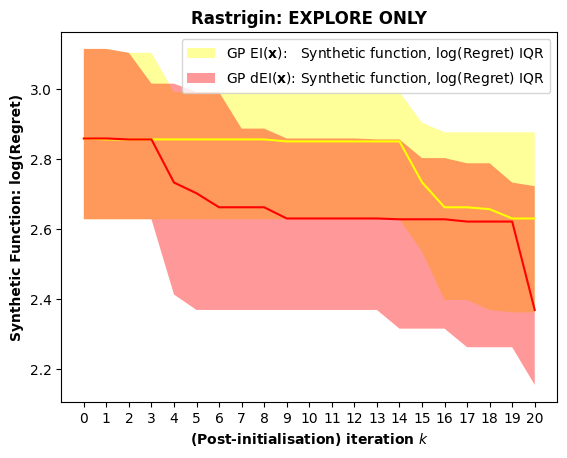

In [163]:
### Visualise!

ei_explore = ': EXPLORE ONLY'
title = obj_func + ei_explore

plt.figure()

plt.plot(median_approx, color = 'Yellow')
plt.plot(median_exact, color = 'Red')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='GP EI($\mathbf{x}$):   Synthetic function, log(Regret) IQR')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Red', alpha=0.4, label='GP dEI($\mathbf{x}$): Synthetic function, log(Regret) IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show()


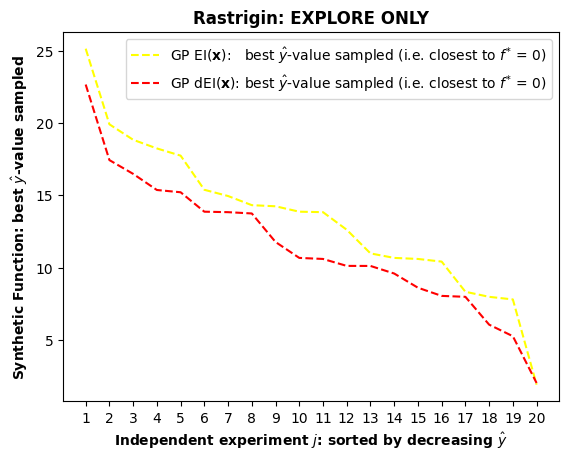

In [164]:
### Visualise!

ei_explore = ': EXPLORE ONLY'
title = obj_func + ei_explore

plt.figure()

plt.plot(np.sort(approx_tau)[::-1], color = 'Yellow', ls='--', label='GP EI($\mathbf{x}$):   best $\it{\hat{y}}$-value sampled (i.e. closest to $\it{f^{*}}$ = 0)')
plt.plot(np.sort(exact_tau)[::-1], color = 'Red', ls='--', label='GP dEI($\mathbf{x}$): best $\it{\hat{y}}$-value sampled (i.e. closest to $\it{f^{*}}$ = 0)')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$: sorted by decreasing $\it{\hat{y}}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: best $\it{\hat{y}}$-value sampled', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


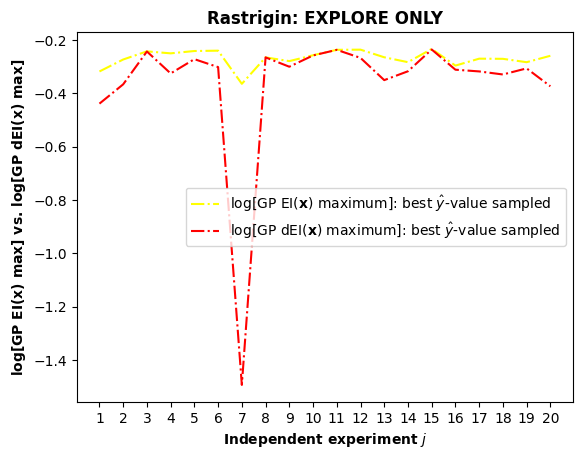

In [165]:
### Visualise!

ei_explore = ': EXPLORE ONLY'
title = obj_func + ei_explore

plt.figure()

plt.plot(np.log(exact_acqFuncApproxBest), color = 'Yellow', ls='-.', label='log[GP EI($\mathbf{x}$) maximum]: best $\it{\hat{y}}$-value sampled')
plt.plot(np.log(exact_acqFuncExactBest), color = 'Red', ls='-.', label='log[GP dEI($\mathbf{x}$) maximum]: best $\it{\hat{y}}$-value sampled')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('log[GP EI($\mathbf{x}$) max] vs. log[GP dEI($\mathbf{x}$) max]', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


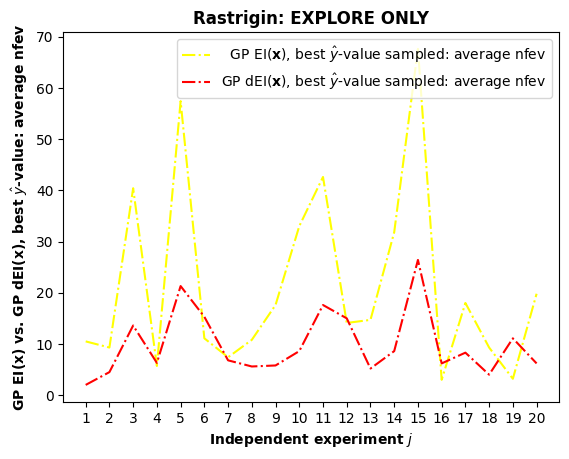

In [166]:
### Visualise!

ei_explore = ': EXPLORE ONLY'
title = obj_func + ei_explore

plt.figure()

plt.plot(approx_nfev_Avg, color = 'Yellow', ls='-.', label='  GP EI($\mathbf{x}$), best $\it{\hat{y}}$-value sampled: average nfev')
plt.plot(exact_nfev_Avg, color = 'Red', ls='-.', label='GP dEI($\mathbf{x}$), best $\it{\hat{y}}$-value sampled: average nfev')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP EI($\mathbf{x}$) vs. GP dEI($\mathbf{x}$), best $\it{\hat{y}}$-value: average nfev', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


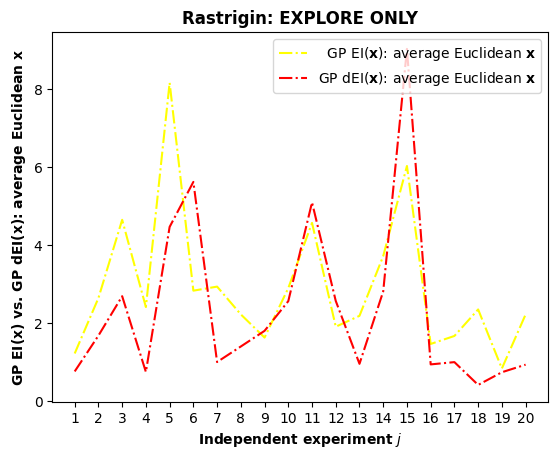

In [167]:
### Visualise!

ei_explore = ': EXPLORE ONLY'
title = obj_func + ei_explore

plt.figure()

plt.plot(approx_euclid_Avg, color = 'Yellow', ls='-.', label='  GP EI($\mathbf{x}$): average Euclidean $\mathbf{x}$')
plt.plot(exact_euclid_Avg, color = 'Red', ls='-.', label='GP dEI($\mathbf{x}$): average Euclidean $\mathbf{x}$')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP EI($\mathbf{x}$) vs. GP dEI($\mathbf{x}$): average Euclidean $\mathbf{x}$', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


In [168]:
np.round(-approx_4.f_best, 4), np.max(np.round(-approx_4.f_best, 4)), approx_4.best


(array([0.737 , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.7515,
        0.7272, 0.77  , 0.7615, 0.    , 0.737 , 0.7272, 0.7255, 0.    ,
        0.    , 0.    , 0.    , 0.737 ]),
 0.77,
 array([0.59931276, 5.12      ]))

In [169]:
np.round(-approx_4.f_best2, 4), np.max(np.round(-approx_4.f_best2, 4)), approx_4.best2


(array([0.7274, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.1139,
        0.1021, 0.417 , 0.6748, 0.    , 0.7274, 0.6634, 0.6234, 0.    ,
        0.    , 0.    , 0.    , 0.7275]),
 0.7275,
 array([-1.904247  ,  0.14717908]))

In [170]:
np.round(approx_4.x_best, 4)


array([[-1.7002, -0.0747],
       [-4.9702, -3.2222],
       [ 0.5714,  1.8134],
       [ 1.48  ,  4.5829],
       [-1.41  ,  3.7074],
       [ 2.569 ,  2.0285],
       [ 3.5203,  4.0042],
       [ 2.3377, -4.23  ],
       [-3.7065, -0.4522],
       [ 0.5993,  5.12  ],
       [ 0.3688,  4.601 ],
       [ 1.3429, -4.1896],
       [-1.7002, -0.0747],
       [-3.7147, -0.4823],
       [ 1.6973,  1.7233],
       [ 1.6219,  3.5906],
       [ 3.6854, -4.4602],
       [ 4.3745, -0.7374],
       [ 1.3018, -2.21  ],
       [-1.7002, -0.0747]])

In [171]:
np.round(approx_4.x_best2, 4)


array([[-1.5022, -0.4148],
       [-4.9702, -3.2222],
       [ 0.5714,  1.8134],
       [ 1.48  ,  4.5829],
       [-1.41  ,  3.7074],
       [ 2.569 ,  2.0285],
       [ 3.5203,  4.0042],
       [ 2.018 , -4.4809],
       [-3.5988,  0.2262],
       [ 0.5634,  4.8064],
       [ 0.6729,  3.1798],
       [ 1.3429, -4.1896],
       [-1.5246, -0.3416],
       [-3.6111, -0.3492],
       [ 0.8974,  3.0445],
       [ 1.6219,  3.5906],
       [ 3.6854, -4.4602],
       [ 4.3745, -0.7374],
       [ 1.3018, -2.21  ],
       [-1.9042,  0.1472]])

In [172]:
np.sqrt(np.sum((approx_4.start_points_arr - approx_4.x_best)**2))


2.591091211538042

In [173]:
np.sqrt(np.sum((approx_4.start_points_arr - approx_4.x_best2)**2))

0.7050186161923662